<a href="https://colab.research.google.com/github/zmalk/zmalk/blob/main/analysis/productivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import annotations

!pip install cliffs-delta

from cliffs_delta import cliffs_delta
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Dict, Any, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from scipy import stats

FONT_SCALE = 1.4  # ← master knob
_BASE_FONT = 10

SECONDS_TO_HOUR = 3600
SECONDS_TO_DAY = 86_400

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=FONT_SCALE)

plt.rcParams.update({
    "font.size": _BASE_FONT * FONT_SCALE,
    "axes.titlesize": _BASE_FONT * FONT_SCALE * 1.2,
    "axes.labelsize": _BASE_FONT * FONT_SCALE,
    "xtick.labelsize": _BASE_FONT * FONT_SCALE * 0.9,
    "ytick.labelsize": _BASE_FONT * FONT_SCALE * 0.9,
    "legend.fontsize": _BASE_FONT * FONT_SCALE * 0.9,
})

try:
  from helper import (  # type: ignore
      FIG_DIR,
      COLOR_MAP,
      NAME_MAPPING,
      FLOW_ORDER,
      mannUandCliffdelta,  # statistical tests
  )
except Exception:
  FIG_DIR = Path("figs")
  FIG_DIR.mkdir(exist_ok=True)
  COLOR_MAP = {
    "Human": "#56B4E9",
    "OpenAI_Codex": "#D55E00",
    "OpenAI Codex": "#D55E00",
    "Codex": "#F0E442",
    "Devin": "#009E73",
    "Copilot": "#0072B2",
    "GitHub Copilot": "#0072B2",
    "Cursor": "#785EF0",
    "Claude_Code": "#DC267F",
    "Claude Code": "#DC267F",
  }
  NAME_MAPPING = {
    "OpenAI_Codex": "OpenAI Codex",
    "Codex": "OpenAI Codex",
    "Devin": "Devin",
    "Copilot": "GitHub Copilot",
    "Cursor": "Cursor",
    "Claude_Code": "Claude Code",
    "Claude": "Claude Code",
    "Human": "Human",
    "OpenAI Codex": "OpenAI Codex",
    "GitHub Copilot": "GitHub Copilot",
    "Claude Code": "Claude Code",
  }
  for key, value in NAME_MAPPING.items():
      if key not in COLOR_MAP:
          COLOR_MAP[key] = COLOR_MAP[value]
  FLOW_ORDER = [
    "feat",  # new functionality
    "fix",  # bug fixes
    "perf",  # performance work
    "refactor",  # code reshaping
    "style",  # lint / formatting
    "docs",  # documentation
    "test",  # testing
    "chore",  # misc maintenance
    "build",  # packaging / build sys
    "ci",  # continuous-integration
    "other",  # continuous-integration
  ]
  def mannUandCliffdelta(dist1, dist2):
    d, size = cliffs_delta(dist1, dist2)
    print(f"Cliff's delta: {size}, d={d}")
    u, p = stats.mannwhitneyu(dist1, dist2, alternative="two-sided")
    print(f"Mann-Whitney-U-test: u={u} p={p}")
    return u, p, d, size


# =============================================================================
# Hugging Face dataset locations
# =============================================================================
# AI Agents
HF_PR_PATH = "hf://datasets/hao-li/AIDev/pull_request.parquet"
HF_REPO_PATH = "hf://datasets/hao-li/AIDev/repository.parquet"
HF_LABEL_PATH = "hf://datasets/hao-li/AIDev/pr_task_type.parquet"

# Human Data
HF_HUMAN_PR_PATH = "hf://datasets/hao-li/AIDev/human_pull_request.parquet"
HF_HUMAN_LABEL_PATH = "hf://datasets/hao-li/AIDev/human_pr_task_type.parquet"


# =============================================================================
# Data container (explicitly passed everywhere)
# =============================================================================
@dataclass(frozen=True)
class HFData:
    """All loaded, unified dataframes."""
    pr_df: pd.DataFrame  # concatenated AI + Human PRs
    lbl_df: pd.DataFrame  # concatenated AI + Human labels
    repo_df: pd.DataFrame | None  # repositories (may be None if not requested)


In [ ]:
def _read_parquet_safely(path: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    return df


def load_hf_data(*,
                 stars_range: list[float | int | None] | tuple[float | int | None, float | int | None] | None = None,
                 include_repo: bool = False) -> HFData:
    """
    Load PRs + labels (AI + Human), optionally filter by a repo stars range.

    Args:
        stars_range: [lower_bound, upper_bound] star filter.
            - lower_bound (inclusive) can be None for no lower limit.
            - upper_bound (inclusive) can be None for no upper limit.
        include_repo: Also load and return repository dataframe.

    Returns:
        HFData with pr_df, lbl_df, and optionally repo_df.
    """
    # --- PRs (AI + Human) ---
    pr_ai = _read_parquet_safely(HF_PR_PATH)
    pr_human = _read_parquet_safely(HF_HUMAN_PR_PATH)

    for df in (pr_ai, pr_human):
        for col in ["created_at", "closed_at", "merged_at"]:
            if col in df.columns and df[col].dtype != "datetime64[ns, UTC]":
                df[col] = pd.to_datetime(df[col], utc=True, errors="coerce")

    pr_all = pr_ai

    # --- Labels (AI + Human) ---
    lbl_ai = _read_parquet_safely(HF_LABEL_PATH)
    lbl_human = _read_parquet_safely(HF_HUMAN_LABEL_PATH)

    for df in (lbl_ai, lbl_human):
        if "type" in df.columns:
            df["type"] = df["type"].astype(str).str.strip()

    lbl_all = lbl_ai

    repo_df: pd.DataFrame | None = None

    # --- Optional star filtering ---
    if stars_range is not None:
        if not (isinstance(stars_range, (list, tuple)) and len(stars_range) == 2):
            raise ValueError("stars_range must be a 2-element list or tuple: [lower, upper]")

        lower_bound, upper_bound = stars_range
        repo_df = _read_parquet_safely(HF_REPO_PATH)

        if "url" in repo_df.columns and "stars" in repo_df.columns and "repo_url" in pr_all.columns:
            mask = repo_df["url"].notna()
            if lower_bound is not None:
                mask &= repo_df["stars"] >= lower_bound
            if upper_bound is not None:
                mask &= repo_df["stars"] <= upper_bound

            good_repo_urls = set(repo_df.loc[mask, "url"].astype(str).unique())
            pr_all = pr_all[pr_all["repo_url"].astype(str).isin(good_repo_urls)].copy()

            if "id" in lbl_all.columns and "id" in pr_all.columns:
                keep_ids = set(pr_all["id"].unique())
                lbl_all = lbl_all[lbl_all["id"].isin(keep_ids)].copy()
        # else: schema mismatch → skip filtering but still return frames
    elif include_repo:
        repo_df = _read_parquet_safely(HF_REPO_PATH)

    pr_all = pd.concat([pr_all, pr_human], ignore_index=True)
    lbl_all = pd.concat([lbl_ai, lbl_human], ignore_index=True)
    return HFData(pr_df=pr_all, lbl_df=lbl_all, repo_df=repo_df)


# =============================================================================
# CSV/HF helpers (now take HFData explicitly)
# =============================================================================
def load_prs(agent: str, data: HFData) -> pd.DataFrame:
    return data.pr_df.loc[data.pr_df["agent"] == agent].copy()


def load_labels(agent: str, data: HFData) -> pd.DataFrame:
    return data.lbl_df.loc[data.lbl_df["agent"] == agent].copy()


# =============================================================================
# Core analysis
# =============================================================================
def analyze_agent(agent: str, data: HFData) -> pd.DataFrame:
    prs = load_prs(agent, data)
    labels = load_labels(agent, data)

    if prs.empty or labels.empty:
        return pd.DataFrame(
            columns=["total", "open_pct", "closed_pct",
                     "merged_pct", "median_hours", "median_hours_closed",
                     "median_hours_merged"]
        )

    df = prs.merge(labels[["id", "type"]], on="id", how="inner")

    # status & turnaround
    df["status"] = np.select(
        [df["state"] == "open", pd.notna(df["merged_at"])],
        ["open", "merged"],
        default="closed",
    )
    df["end_at"] = df["merged_at"].fillna(df["closed_at"])
    df["turnaround_hours"] = (
                                     df["end_at"] - df["created_at"]
                             ).dt.total_seconds() / SECONDS_TO_HOUR

    def summarise(group: pd.DataFrame) -> pd.Series:
        stats = {
            "total": len(group),
            "open_pct": 100 * (group["status"] == "open").mean(),
            "closed_pct": 100 * (group["status"] == "closed").mean(),
            "merged_pct": 100 * (group["status"] == "merged").mean(),
        }
        non_open = group[group["status"] != "open"]
        stats["median_hours"] = non_open["turnaround_hours"].median()
        stats["median_hours_closed"] = group[group["status"] == "closed"]["turnaround_hours"].median()
        stats["median_hours_merged"] = group[group["status"] == "merged"]["turnaround_hours"].median()
        return pd.Series(stats)

    out = (df.groupby("type").apply(summarise)
           .sort_values("total", ascending=False))
    return out


# =============================================================================
# Visualisations (unchanged logic; accept data bundle)
# =============================================================================
def gather_merged_pct(agents: Iterable[str],
                      data,
                      min_instances: int = 5) -> pd.DataFrame:
    rows: list[pd.DataFrame] = []
    for ag in agents:
        summ = analyze_agent(ag, data)
        summ = summ.loc[(summ.index != "other") &
                        (summ["total"] >= min_instances)]
        if summ.empty:
            continue
        tmp = summ.reset_index()[["type", "merged_pct"]].copy()
        tmp["agent"] = ag
        rows.append(tmp)
    return (pd.concat(rows, ignore_index=True)
            if rows else pd.DataFrame(columns=["agent", "type", "merged_pct"]))


def plot_merged_pct_radar_all_in_one(df: pd.DataFrame, out_fp: Path) -> None:
    if df.empty:
        print("No data to plot.")
        return
    pref = ["Human", "OpenAI_Codex", "Devin",
            "Copilot", "Cursor", "Claude_Code"]
    nice = {"Human": "Human", "OpenAI_Codex": "OpenAI Codex",
            "Devin": "Devin", "Copilot": "GitHub Copilot",
            "Cursor": "Cursor", "Claude_Code": "Claude Code"}

    cats = [c for c in FLOW_ORDER if c in df["type"].unique()]
    theta = np.linspace(0, 2 * np.pi, len(cats), endpoint=False)[::-1]
    theta = np.concatenate([theta[4:], theta[:4]])  # move "feat" to the top
    theta = np.r_[theta, theta[0]]

    fig, ax = plt.subplots(figsize=(7, 7),
                           subplot_kw={"polar": True})
    for ag in (a for a in pref if a in df["agent"].unique()):
        s = df.loc[df["agent"] == ag].set_index("type")["merged_pct"]
        vals = [s.get(c, 0) for c in cats] + [s.get(cats[0], 0)]
        ax.plot(theta, vals, lw=2.5 if ag == "Human" else 1.5,
                label=nice[ag], color=COLOR_MAP.get(ag, "#444"))
        ax.fill(theta, vals, alpha=.35 if ag == "Human" else .20,
                color=COLOR_MAP.get(ag, "#444"))

    ax.set_xticks(theta[:-1])
    ax.set_xticklabels(cats)
    ax.set_ylim(0, 100)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([f"{y}%" for y in [0, 25, 50, 75, 100]])
    ax.set_rlabel_position(90)
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2),
              ncol=math.ceil(df["agent"].nunique() / 2), frameon=False)

    fig.tight_layout()
    out_fp = Path(out_fp)
    out_fp.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_fp, dpi=300)
    fig.savefig(out_fp.with_suffix(".png"), dpi=300)
    plt.close(fig)
    print("Wrote", out_fp)


def _radar_trace(ax,
                 s: pd.Series,
                 cats: List[str],
                 theta: np.ndarray,
                 *,
                 label: str,
                 colour: str,
                 lw: float = 1.5,
                 fill: bool = True,
                 alpha: float = 0.25,
                 marker_size: float = 4.0) -> None:
    vals = [s.get(c, 0) for c in cats] + [s.get(cats[0], 0)]
    ax.plot(theta, vals, lw=lw, color=colour, label=label,
            marker="o", markersize=marker_size, markerfacecolor=colour)
    if fill:
        ax.fill(theta, vals, alpha=alpha, color=colour)


def plot_merged_pct_radar(df: pd.DataFrame,
                          out_fp: Path | str,
                          *,
                          font_size: int = 15) -> None:
    if df.empty:
        print("❗  No data to plot.")
        return

    plt.rcParams.update({"font.size": font_size})

    pref_order = [
        "OpenAI_Codex",
        "Devin",
        "Copilot",
        "Cursor",
        "Claude_Code",
    ]
    pretty = {
        "Human": "Human",
        "OpenAI_Codex": "OpenAI Codex",
        "Devin": "Devin",
        "Copilot": "GitHub Copilot",
        "Cursor": "Cursor",
        "Claude_Code": "Claude Code",
    }

    cats = [c for c in FLOW_ORDER if c in df["type"].unique()]
    if not cats:
        print("❗  No recognised *type* categories found in the data.")
        return

    theta = np.linspace(0, 2 * np.pi, len(cats), endpoint=False)[::-1]
    theta = np.concatenate([theta[4:], theta[:4]])  # 'feat' to the top
    theta = np.r_[theta, theta[0]]  # close loop

    agents: List[str] = [a for a in pref_order if a in df["agent"].unique()][:5]
    if not agents:
        print("❗  No comparison agents found in the data.")
        return

    # Pre-compute baseline (Human) percentages if available
    have_human = "Human" in df["agent"].unique()
    if have_human:
        human_s = df.loc[df["agent"] == "Human"].set_index("type")["merged_pct"]
    else:
        human_s = pd.Series(dtype=float)

    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(nrows=2, ncols=6)

    slots = [
        (0, slice(0, 2)),
        (0, slice(2, 4)),
        (0, slice(4, 6)),
        (1, slice(1, 3)),
        (1, slice(3, 5)),
    ]

    axes: list[plt.Axes] = []
    for agent, (r, csl) in zip(agents, slots):
        ax = fig.add_subplot(gs[r, csl], polar=True)
        axes.append(ax)

        # baseline (Human) if present
        if have_human:
            _radar_trace(
                ax, human_s, cats, theta,
                label="Human",
                colour=COLOR_MAP.get("Human", "#222"),
                lw=2.5,
                fill=True,
                alpha=0.10,
            )

        # agent trace
        agent_s = df.loc[df["agent"] == agent].set_index("type")["merged_pct"]
        _radar_trace(
            ax, agent_s, cats, theta,
            label=pretty.get(agent, agent),
            colour=COLOR_MAP.get(agent, "#444"),
            lw=1.5,
            fill=True,
            alpha=0.70,
        )

        ax.set_xticks(theta[:-1])
        ax.set_xticklabels(cats, fontsize=font_size + 1)
        ax.set_ylim(0, 100)
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([f"{y}%" for y in [0, 25, 50, 75, 100]],
                           fontsize=font_size - 2)
        ax.set_rlabel_position(54)
        subtitle = f"{'Human vs. ' if have_human else ''}{pretty.get(agent, agent)}"
        ax.text(0.5, -0.12, subtitle, ha="center", va="top",
                fontsize=font_size + 1, transform=ax.transAxes)

    legend_labels = (["Human"] if have_human else []) + [pretty.get(a, a) for a in agents]
    legend_handles = (
                         [Patch(facecolor=COLOR_MAP.get("Human", "#222"), alpha=0.6, edgecolor="none", label="Human")]
                         if have_human else []
                     ) + [
                         Patch(facecolor=COLOR_MAP.get(a, "#444"), alpha=0.6, edgecolor="none", label=pretty.get(a, a))
                         for a in agents
                     ]

    if legend_handles:
        fig.legend(
            handles=legend_handles,
            labels=legend_labels,
            loc="lower left",
            bbox_to_anchor=(0.02, 0.01),
            ncol=1,
            fontsize=font_size,
            frameon=False,
        )

    fig.tight_layout()
    out_fp = Path(out_fp)
    out_fp.parent.mkdir(parents=True, exist_ok=True)
    pdf_fp, png_fp = out_fp.with_suffix(".pdf"), out_fp.with_suffix(".png")
    fig.savefig(pdf_fp, dpi=300)
    fig.savefig(png_fp, dpi=300)
    plt.show()
    plt.close(fig)
    print(f"✓ wrote:\n  • {pdf_fp}\n  • {png_fp}")


def plot_merged_pct_radar2(df: pd.DataFrame,
                           out_fp: Path | str,
                           *,
                           font_size: int = 15) -> None:
    """
    Build a single figure (≤5 radar sub-plots) comparing *merged_pct* across
    agents and save it as <stem>.pdf and <stem>.png.

    If "Human" exists, each agent is plotted as a percentage of Human for
    each category (Human baseline = 100%). If "Human" is absent, absolute
    percentages are plotted and the baseline cue/legend entry are omitted.
    """
    if df.empty:
        print("❗  No data to plot.")
        return

    plt.rcParams.update({"font.size": font_size})

    # Preferred ordering of agents (show max five, excluding the baseline Human)
    pref_order = ["OpenAI_Codex", "Devin", "Copilot", "Cursor", "Claude_Code"]
    pretty = {
        "Human": "Human",
        "OpenAI_Codex": "OpenAI Codex",
        "Devin": "Devin",
        "Copilot": "GitHub Copilot",
        "Cursor": "Cursor",
        "Claude_Code": "Claude Code",
    }

    # Categories present, kept in FLOW_ORDER order
    cats = [c for c in FLOW_ORDER if c in df["type"].unique()]
    if not cats:
        print("❗  No recognised *type* categories found in the data.")
        return

    # Polar angles, rotated so 'feat' sits at 12 o’clock
    theta = np.linspace(0, 2 * np.pi, len(cats), endpoint=False)[::-1]
    theta = np.concatenate([theta[4:], theta[:4]])  # 'feat' to the top
    theta = np.r_[theta, theta[0]]  # close loop

    have_human = "Human" in df["agent"].unique()
    human_s = (df.loc[df["agent"] == "Human"]
               .set_index("type")["merged_pct"]
               .reindex(cats))

    # Non-Human agents to show (limit to five)
    agents: List[str] = [a for a in pref_order if a in df["agent"].unique()][:5]
    if not agents:
        print("❗  No comparison agents found in the data.")
        return

    # ───────────────────────── Figure layout (5 sub-plots) ─────────────────────
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(nrows=2, ncols=6)
    slots = [
        (0, slice(0, 2)),  # row-0, cols 0-1
        (0, slice(2, 4)),  # row-0, cols 2-3
        (0, slice(4, 6)),  # row-0, cols 4-5
        (1, slice(1, 3)),  # row-1, cols 1-2
        (1, slice(3, 5)),  # row-1, cols 3-4
    ]

    # Helper: compute values to plot (relative to Human if available)
    def _values_for(agent: str) -> pd.Series:
        s = (df.loc[df["agent"] == agent]
             .set_index("type")["merged_pct"]
             .reindex(cats))
        if have_human:
            # 100 * agent/human, safe divide; treat 0/NaN human as NaN
            denom = human_s.astype(float)
            numer = s.astype(float)
            with np.errstate(divide="ignore", invalid="ignore"):
                rel = 100.0 * numer / denom
            return rel.fillna(0.0)
        else:
            return s  # absolute % merged

    # ───────────────────────────── Plot sub-panels ─────────────────────────────
    axes: list[plt.Axes] = []
    for agent, (r, csl) in zip(agents, slots):
        ax = fig.add_subplot(gs[r, csl], polar=True)
        axes.append(ax)

        # Emphasize 100% circle when we’re in relative mode
        if have_human:
            ax.plot(theta, [100.0] * len(theta), color="black",
                    lw=1.5, ls="--", alpha=0.7)

        # Agent trace
        agent_vals = _values_for(agent)
        _radar_trace(
            ax,
            agent_vals.reindex(cats),
            cats,
            theta,
            label=pretty.get(agent, agent),
            colour=COLOR_MAP.get(agent, "#444"),
            lw=1.5,
            fill=True,
            alpha=0.70,
        )

        # Cosmetics
        ax.set_xticks(theta[:-1])
        ax.set_xticklabels(cats, fontsize=font_size + 1)

        if have_human:
            ax.set_ylim(0, 125)
            ax.set_yticks([0, 25, 50, 75, 100, 125])
            ax.set_yticklabels([f"{y}%" for y in [0, 25, 50, 75, 100, 125]],
                               fontsize=font_size - 2)
            subtitle = f"{pretty.get(agent, agent)} / Human"
        else:
            ax.set_ylim(0, 100)
            ax.set_yticks([0, 25, 50, 75, 100])
            ax.set_yticklabels([f"{y}%" for y in [0, 25, 50, 75, 100]],
                               fontsize=font_size - 2)
            subtitle = pretty.get(agent, agent)

        ax.set_rlabel_position(54)
        ax.text(0.5, -0.12, subtitle, ha="center", va="top",
                fontsize=font_size + 1, transform=ax.transAxes)

    # ───────────────────────────── Consolidated legend ─────────────────────────
    legend_handles = []
    legend_labels = []

    if have_human:
        human_handle = Patch(
            facecolor="none",
            edgecolor="#000000",
            linestyle="--",
            linewidth=1.5,
            label="Human (100%)"
        )
        legend_handles.append(human_handle)
        legend_labels.append("Human (100%)")

    for a in agents:
        legend_handles.append(
            Patch(facecolor=COLOR_MAP.get(a, "#444"),
                  alpha=0.6, edgecolor="none", label=pretty.get(a, a))
        )
        legend_labels.append(pretty.get(a, a))

    fig.legend(
        handles=legend_handles,
        labels=legend_labels,
        loc="lower left",
        bbox_to_anchor=(0.02, 0.01),
        ncol=1,  # vertical
        fontsize=font_size,
        frameon=False,
    )

    fig.tight_layout()  # leave room for legend

    out_fp = Path(out_fp)
    out_fp.parent.mkdir(parents=True, exist_ok=True)
    pdf_fp, png_fp = out_fp.with_suffix(".pdf"), out_fp.with_suffix(".png")
    fig.savefig(pdf_fp, dpi=300)
    fig.savefig(png_fp, dpi=300)
    plt.show()
    plt.close(fig)
    print(f"✓ wrote:\n  • {pdf_fp}\n  • {png_fp}")


def gather_median_hours(agents: Iterable[str], data: HFData) -> pd.DataFrame:
    rows = []
    for ag in agents:
        summ = analyze_agent(ag, data)
        if summ.empty:
            continue
        rows.append({
            "agent": ag,
            "median_hours_closed": summ["median_hours_closed"].median(),
            "median_hours_merged": summ["median_hours_merged"].median(),
        })
    return pd.DataFrame(rows)


# =============================================================================
# Enhanced turnaround-comparison table helpers
# =============================================================================
_STATUS_REMAP = {"closed": "Reject", "merged": "Accept"}
_PALETTE = {"Reject": "#DC267F", "Accept": "#0072B2"}


def gather_turnaround_distribution(
        agents: Iterable[str],
        data: HFData,
) -> pd.DataFrame:
    """
    Return tidy DataFrame with columns:
        agent · status · turnaround_hours
    """
    frames: list[pd.DataFrame] = []
    for ag in agents:
        prs = load_prs(ag, data)
        lbls = load_labels(ag, data)
        if prs.empty or lbls.empty:
            continue

        df = prs.merge(lbls[["id"]], on="id", how="inner")
        df["status"] = np.select(
            [df["state"] == "open", pd.notna(df["merged_at"])],
            ["open", "merged"],
            default="closed",
        )
        df["end_at"] = df["merged_at"].fillna(df["closed_at"])
        df["turnaround_hours"] = (
                                         df["end_at"] - df["created_at"]
                                 ).dt.total_seconds() / SECONDS_TO_HOUR

        df = df[df["status"].isin(_STATUS_REMAP)]
        if df.empty:
            continue
        df["status"] = df["status"].map(_STATUS_REMAP)
        df["agent"] = ag
        frames.append(df[["agent", "status", "turnaround_hours"]])

    return (pd.concat(frames, ignore_index=True)
            if frames else pd.DataFrame())


def plot_turnaround_box(
        df: pd.DataFrame,
        out_fp: Path,
        *,
        log_scale: bool = True,
        baseline_agent: str = "Human",
) -> None:
    if df.empty:
        print("No data to plot.")
        return

    accept_medians = (df[df["status"] == "Accept"]
                      .groupby("agent")["turnaround_hours"]
                      .median()
                      .sort_values())

    ordered_agents = ([baseline_agent] +
                      [a for a in accept_medians.index
                       if a != baseline_agent and a in df["agent"].unique()])

    fig, ax = plt.subplots(figsize=(12, 6))
    for ag in ordered_agents:
        ag_df = df[df["agent"] == ag]
        for status in ["Accept", "Reject"]:
            ag_status_df = ag_df[ag_df["status"] == status]
            if not ag_status_df.empty:
                print(f"{ag} ({status}):",
                      ag_status_df["turnaround_hours"].describe())

    sns.boxplot(
        data=df, x="agent", y="turnaround_hours",
        order=ordered_agents,
        hue="status",
        hue_order=["Accept", "Reject"],
        palette=_PALETTE,
        showcaps=True, showfliers=True, width=0.65,
        saturation=0.8, linewidth=1.2, ax=ax,
        medianprops={"linewidth": 2, "color": "#000000"},
    )

    ax.set_xlabel("")
    ax.set_ylabel("Turnaround Time")
    if log_scale:
        ax.set_yscale("symlog")
    ax.set_ylim(-0.1)
    hours_yticks = [0, 1, 2, 8, 24, 24 * 3, 24 * 7, 24 * 30, 24 * 180]
    ax.set_yticks(hours_yticks)
    ax.set_yticklabels([
        f"{h}h" if h < 24 else f"{h // 24}d" if h < 24 * 30 else f"{h // (24 * 30)}mo"
        for h in hours_yticks
    ])

    handles, labels = ax.get_legend_handles_labels()
    uniq = [(h, l) for i, (h, l) in enumerate(zip(handles, labels))
            if l not in labels[:i]]
    ax.legend(*zip(*uniq), frameon=False, ncol=2, loc="upper right")

    # Replace underscores with spaces / nicer names
    ax.set_xticklabels([NAME_MAPPING.get(lbl.get_text(), lbl.get_text())
                        for lbl in ax.get_xticklabels()])

    fig.tight_layout()
    out_fp = Path(out_fp)
    out_fp.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_fp, dpi=300)
    fig.savefig(out_fp.with_suffix(".png"), dpi=300)
    plt.show()
    plt.close(fig)
    print("Wrote", out_fp)
    print("Wrote", out_fp.with_suffix(".png"))


# =============================================================================
# ──────────────── Enhanced table (FIXED Accept/Reject rate) ────────────────
# =============================================================================
def _signif(p: float, alpha: float = .05) -> str:
    return "*" if p < alpha else ""


def _agent_stats(agent: str, data: HFData) -> dict[str, float]:
    """
    Return counts & medians for *all* labeled PRs of one agent.
    Keys: total, accept_cnt, reject_cnt, accept_rate, reject_rate,
          accept_median, reject_median
    """
    prs = load_prs(agent, data)
    lbls = load_labels(agent, data)
    if prs.empty or lbls.empty:
        return {
            "total": 0, "accept_cnt": 0, "reject_cnt": 0,
            "accept_rate": np.nan, "reject_rate": np.nan,
            "accept_median": np.nan, "reject_median": np.nan,
        }

    df = prs.merge(lbls[["id"]], on="id", how="inner")
    df["status"] = np.select(
        [df["state"] == "open", pd.notna(df["merged_at"])],
        ["open", "merged"],
        default="closed",
    )
    df["end_at"] = df["merged_at"].fillna(df["closed_at"])
    df["turnaround_hours"] = (
                                     df["end_at"] - df["created_at"]
                             ).dt.total_seconds() / SECONDS_TO_HOUR

    total = len(df)
    accept_cnt = (df["status"] == "merged").sum()
    reject_cnt = (df["status"] == "closed").sum()

    out: dict[str, float] = {
        "total": total,
        "accept_cnt": accept_cnt,
        "reject_cnt": reject_cnt,
        "accept_rate": 100 * accept_cnt / total if total else np.nan,
        "reject_rate": 100 * reject_cnt / total if total else np.nan,
        "accept_median": df.loc[df["status"] == "merged", "turnaround_hours"].median(),
        "reject_median": df.loc[df["status"] == "closed", "turnaround_hours"].median(),
    }
    return out


def build_enhanced_table(agents: list[str],
                         dist_df: pd.DataFrame,
                         data: HFData,
                         *,
                         baseline: str = "Human") -> pd.DataFrame:
    """
    Multi-index columns:
        ┌──────────────┬──────────────────────────────┐
        │    Accept    │            Reject           │
        │ Sig   Cliff  │  Rate  Med  │ Sig   Cliff   │
        └──────────────┴──────────────────────────────┘
    """
    # per-agent global counts / medians
    global_stats = {ag: _agent_stats(ag, data) for ag in agents}

    # significance & Cliff size vs baseline
    sig_map: Dict[str, Dict[str, str]] = {"Accept": {}, "Reject": {}}
    cliff_map: Dict[str, Dict[str, str]] = {"Accept": {}, "Reject": {}}

    for status in ["Accept", "Reject"]:
        base = dist_df[(dist_df["agent"] == baseline) &
                       (dist_df["status"] == status)]["turnaround_hours"]
        if base.empty:
            for ag in agents:
                sig_map[status][ag] = ""
                cliff_map[status][ag] = ""
            continue

        base = base.to_numpy()
        print("Baseline turnaround hours:")
        print(pd.Series(base).describe())

        for ag in agents:
            if ag == baseline:
                sig_map[status][ag] = ""
                cliff_map[status][ag] = ""
                continue
            sample = dist_df[(dist_df["agent"] == ag) &
                             (dist_df["status"] == status)]["turnaround_hours"]
            if sample.empty:
                sig_map[status][ag] = ""
                cliff_map[status][ag] = ""
                continue
            u, p, _, size = mannUandCliffdelta(sample.to_numpy(), base)
            print("", ag, status, "→ Cliff size:", size, "p-value:", p)
            print("Sample turnaround hours:")
            print(sample.describe())
            sig_map[status][ag] = _signif(p)
            cliff_map[status][ag] = size

    rows: Dict[str, Dict[tuple[str, str], Any]] = {}
    for ag in agents:
        gs = global_stats.get(ag, {})
        rows[ag] = {
            ("Accept", "Rate"): round(gs.get("accept_rate", np.nan), 2),
            ("Accept", "Med"): round(gs.get("accept_median", np.nan), 2),
            ("Accept", "Sig"): sig_map["Accept"].get(ag, "-"),
            ("Accept", "Cliff"): cliff_map["Accept"].get(ag, "-"),

            ("Reject", "Rate"): round(gs.get("reject_rate", np.nan), 2),
            ("Reject", "Med"): round(gs.get("reject_median", np.nan), 2),
            ("Reject", "Sig"): sig_map["Reject"].get(ag, "-"),
            ("Reject", "Cliff"): cliff_map["Reject"].get(ag, "-"),
        }

    cols = pd.MultiIndex.from_product(
        [["Accept", "Reject"], ["Rate", "Med", "Sig", "Cliff"]],
        names=["Status", ""],
    )
    df = pd.DataFrame.from_dict(rows, orient="index", columns=cols)
    df.index.name = "Agent"
    return df


def save_enhanced_table(df: pd.DataFrame, out_fp: Path) -> None:
    """Write CSV + ready-to-use LaTeX."""
    out_fp.parent.mkdir(parents=True, exist_ok=True)

    csv_df = df.copy()
    csv_df.columns = ['_'.join(c).lower() for c in csv_df.columns]
    csv_df.to_csv(out_fp, index=True)
    print(f"✓ CSV:  {out_fp}")

    latex = df.to_latex(
        escape=False, multirow=True, float_format="%.2f",
        caption="Turnaround statistics vs Human (\"*\" denotes $p<0.05$).",
        label="tab:turnaround_enhanced",
    )
    tex_fp = out_fp.with_suffix(".tex")
    print(latex)
    tex_fp.write_text(latex)
    print(f"✓ LaTeX: {tex_fp}")


# =============================================================================
# CLI helpers
# =============================================================================
def get_agents(data: HFData) -> list[str]:
    # only agents that actually have PRs + will join with labels
    agents = sorted(data.pr_df["agent"].dropna().unique().tolist())
    return list(agents)

## All AIDev-pop

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: Da


=== Claude_Code ===
          total  merged_pct
type                       
feat     250.00       56.80
fix      115.00       57.39
docs      32.00       75.00
refactor  26.00       50.00
chore     14.00       71.43
build      8.00       87.50
test       6.00       50.00
ci         5.00       80.00
perf       3.00       66.67

=== Copilot ===
           total  merged_pct
type                        
fix      1993.00       42.40
feat     1661.00       38.05
docs      458.00       60.70
refactor  301.00       47.84
test      167.00       36.53
chore     126.00       43.65
build     121.00       49.59
ci         67.00       62.69
perf       44.00       27.27
style      15.00       40.00
other      12.00        0.00
revert      5.00       80.00


/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut


=== Cursor ===
          total  merged_pct
type                       
feat     616.00       60.39
fix      411.00       68.37
docs     207.00       74.40
refactor 111.00       64.86
chore     50.00       74.00
build     42.00       57.14
test      37.00       62.16
perf      24.00       45.83
style     18.00       72.22
ci        16.00       93.75
other      9.00       33.33

=== Devin ===
           total  merged_pct
type                        
feat     1904.00       54.36
fix      1249.00       42.91
docs      620.00       71.29
refactor  437.00       56.75
chore     281.00       56.58
test      117.00       50.43
build      64.00       57.81
perf       62.00       35.48
ci         59.00       61.02
style      25.00       68.00
revert      6.00       66.67
other       3.00        0.00

=== Human ===
           total  merged_pct
type                        
feat     1946.00       73.48
fix      1778.00       82.40
chore     847.00       78.98
build     614.00       73.45
docs      

/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut


=== OpenAI_Codex ===
            total  merged_pct
type                         
feat     10019.00       80.74
fix       4338.00       81.58
docs      2570.00       92.18
test      2029.00       83.83
refactor  1413.00       79.76
chore      425.00       83.53
build      392.00       86.99
ci         264.00       86.36
perf       207.00       68.12
style      130.00       84.62
other        7.00        0.00
revert       5.00       80.00


/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut

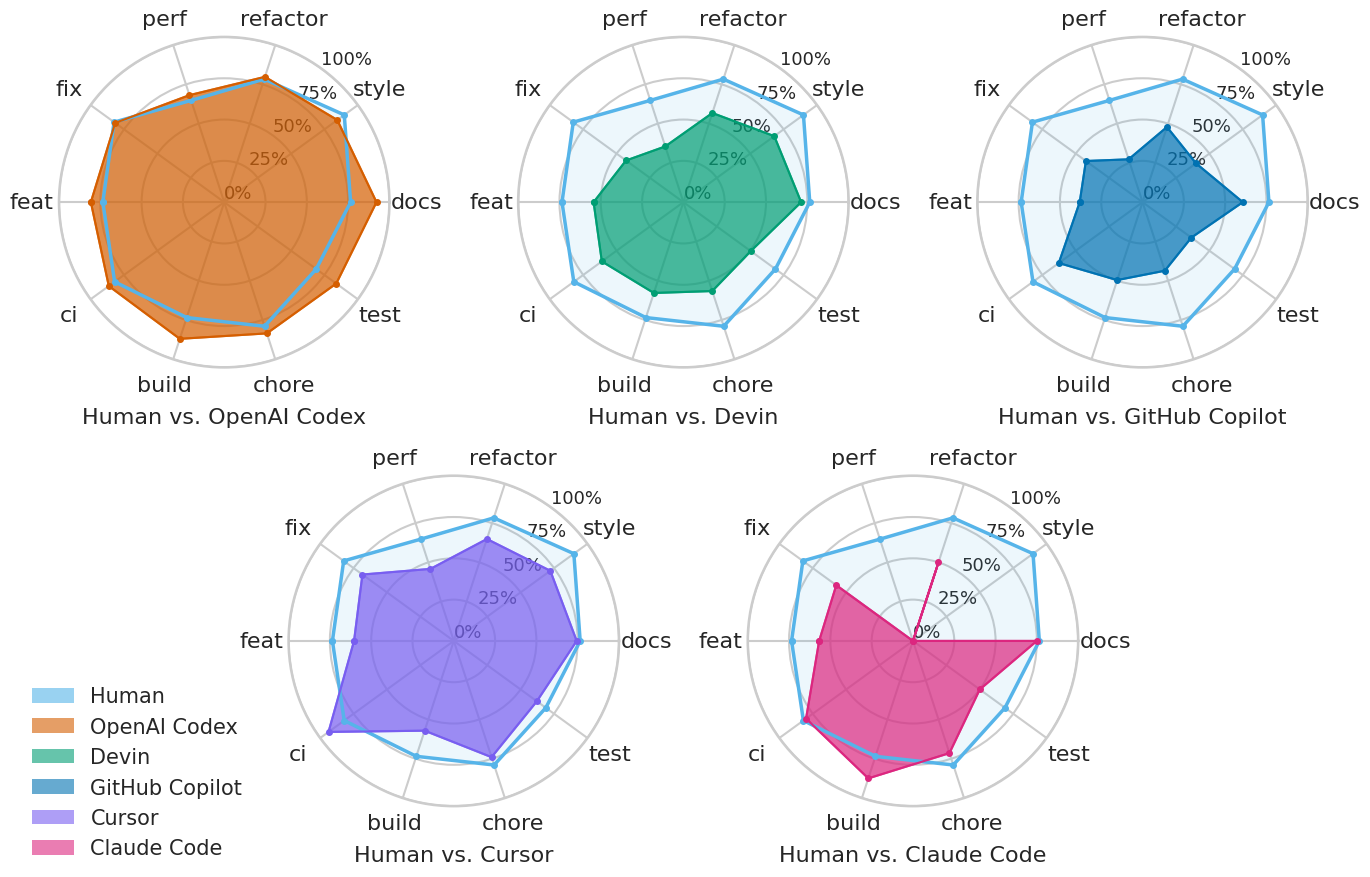

✓ wrote:
  • figs/pr_merge_compare_radar.pdf
  • figs/pr_merge_compare_radar.png


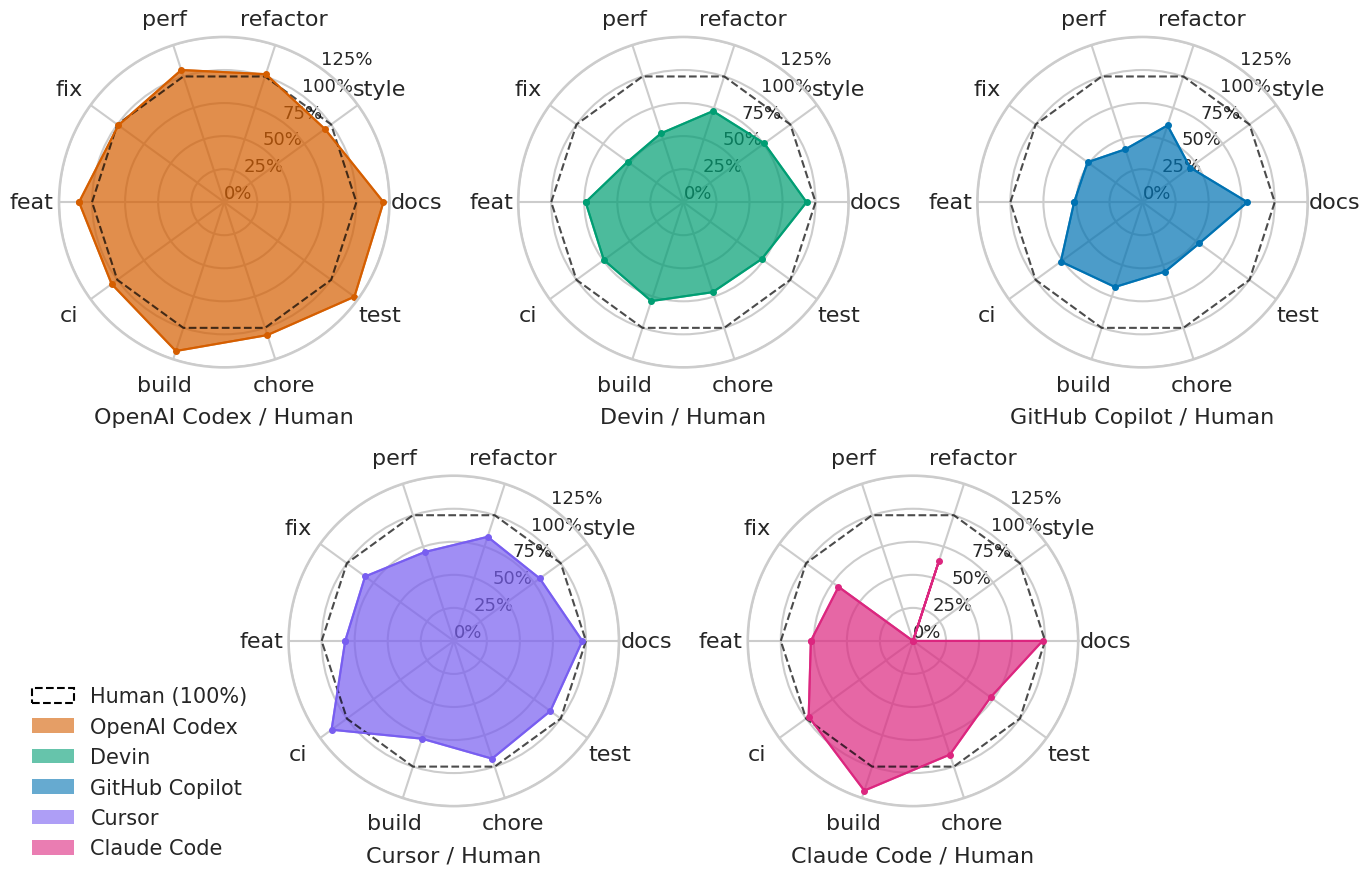

✓ wrote:
  • figs/pr_merge_compare_radar2.pdf
  • figs/pr_merge_compare_radar2.png
Human (Accept): count    5081.000000
mean       63.498462
std       206.833777
min         0.000556
25%         0.411389
50%         3.892778
75%        30.599722
max      3220.455278
Name: turnaround_hours, dtype: float64
Human (Reject): count    1068.000000
mean      233.190097
std       488.981769
min         0.000278
25%         1.241042
50%        27.554722
75%       190.819236
max      3815.923333
Name: turnaround_hours, dtype: float64
OpenAI_Codex (Accept): count    18004.000000
mean         8.722579
std         64.011129
min          0.001389
25%          0.003889
50%          0.014167
75%          0.114167
max       1776.576944
Name: turnaround_hours, dtype: float64
OpenAI_Codex (Reject): count    2989.000000
mean       83.823186
std       233.579134
min         0.000833
25%         0.059444
50%         1.650556
75%        43.457500
max      1620.089722
Name: turnaround_hours, dtype: float64
Cur

/tmp/ipython-input-3121000326.py:621: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([NAME_MAPPING.get(lbl.get_text(), lbl.get_text())


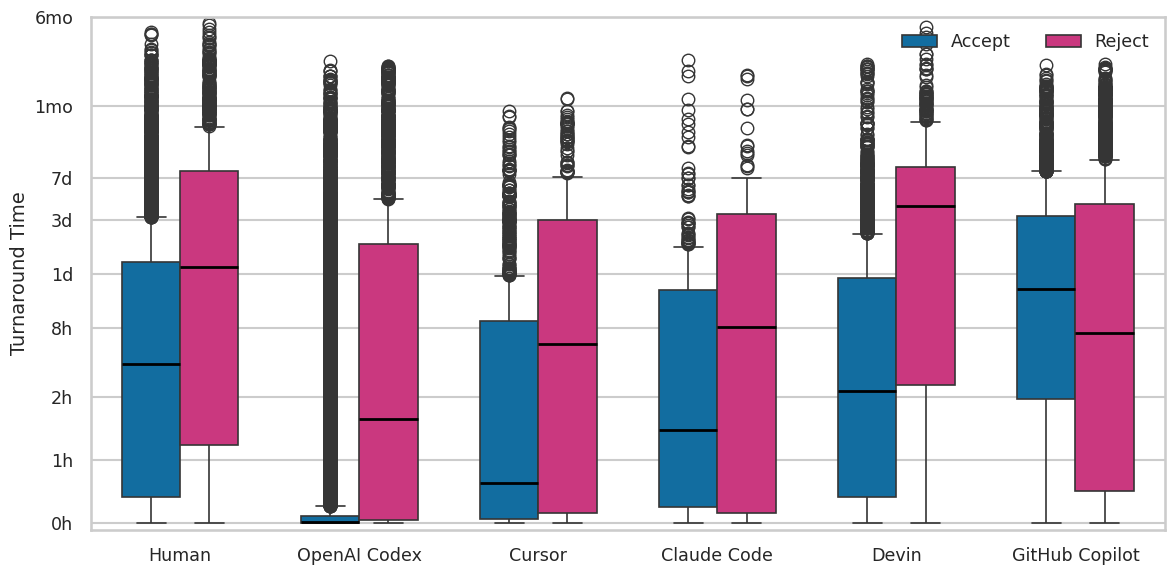

Wrote figs/turnaround_distribution.pdf
Wrote figs/turnaround_distribution.png
Baseline turnaround hours:
count    5081.000000
mean       63.498462
std       206.833777
min         0.000556
25%         0.411389
50%         3.892778
75%        30.599722
max      3220.455278
dtype: float64
Cliff's delta: negligible, d=-0.1262964332064104
Mann-Whitney-U-test: u=601523.5 p=0.0004507997687009145
 Claude_Code Accept → Cliff size: negligible p-value: 0.0004507997687009145
Sample turnaround hours:
count     271.000000
mean       47.470253
std       182.599057
min         0.001667
25%         0.258889
50%         1.473611
75%        17.349444
max      1797.698333
Name: turnaround_hours, dtype: float64
Cliff's delta: small, d=0.24680834345224933
Mann-Whitney-U-test: u=6775318.0 p=9.02557084967527e-62
 Copilot Accept → Cliff size: small p-value: 9.02557084967527e-62
Sample turnaround hours:
count    2139.000000
mean       80.399895
std       168.715113
min         0.009444
25%         1.959167
50%

In [ ]:
# Load unified data once and pass it everywhere
data = load_hf_data()  # optionally: stars_threshold=100, include_repo=True

agents = get_agents(data)

for ag in agents:
    summ = analyze_agent(ag, data)
    if summ.empty:
        print(f"No labelled PRs for {ag}")
        continue
    print(f"\n=== {ag} ===")
    print(summ[["total", "merged_pct"]].to_string(float_format="%.2f"))

# Radar (multi-panel, Human baseline if present)
merged_df = gather_merged_pct(agents, data)
plot_merged_pct_radar(
    merged_df,
    FIG_DIR / "pr_merge_compare_radar.pdf"
)

# Radar v2 (relative to Human when present)
plot_merged_pct_radar2(
    merged_df,
    FIG_DIR / "pr_merge_compare_radar2.pdf"
)

# Turnaround box
dist = gather_turnaround_distribution(agents, data)
plot_turnaround_box(
    dist,
    FIG_DIR / "turnaround_distribution.pdf",
    log_scale=True,
)

# Enhanced table
table_df = build_enhanced_table(agents, dist, data)
save_enhanced_table(table_df, FIG_DIR / "turnaround_enhanced.csv")


### 100 - 500 stars


/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut


=== Claude_Code ===
          total  merged_pct
type                       
feat     114.00       74.56
fix       40.00       77.50
docs      12.00       83.33
refactor   6.00       83.33
build      4.00       75.00
ci         4.00      100.00
chore      1.00      100.00
perf       1.00      100.00
test       1.00      100.00

=== Copilot ===
          total  merged_pct
type                       
feat     606.00       39.11
fix      545.00       44.77
docs     164.00       61.59
refactor  78.00       52.56
chore     61.00       37.70
test      48.00       39.58
build     42.00       52.38
ci        33.00       54.55
perf      10.00       40.00
other      5.00        0.00
revert     2.00       50.00
style      2.00       50.00

=== Cursor ===
          total  merged_pct
type                       
feat     238.00       68.07
fix      137.00       73.72
docs     111.00       78.38
refactor  54.00       70.37
build     18.00       66.67
test      17.00       58.82
chore     15.00       

/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut


=== Human ===
           total  merged_pct
type                        
feat     1946.00       73.48
fix      1778.00       82.40
chore     847.00       78.98
build     614.00       73.45
docs      519.00       76.49
refactor  369.00       78.32
test      183.00       68.85
other     115.00       53.91
ci        100.00       82.00
perf       88.00       64.77
style      59.00       89.83

=== OpenAI_Codex ===
           total  merged_pct
type                        
feat     8640.00       85.46
fix      3054.00       86.51
docs     1902.00       93.59
test     1693.00       88.01
refactor 1103.00       83.59
build     321.00       91.90
chore     278.00       86.33
ci        213.00       90.14
perf      176.00       71.59
style     110.00       87.27
revert      4.00       75.00
other       3.00        0.00


/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut

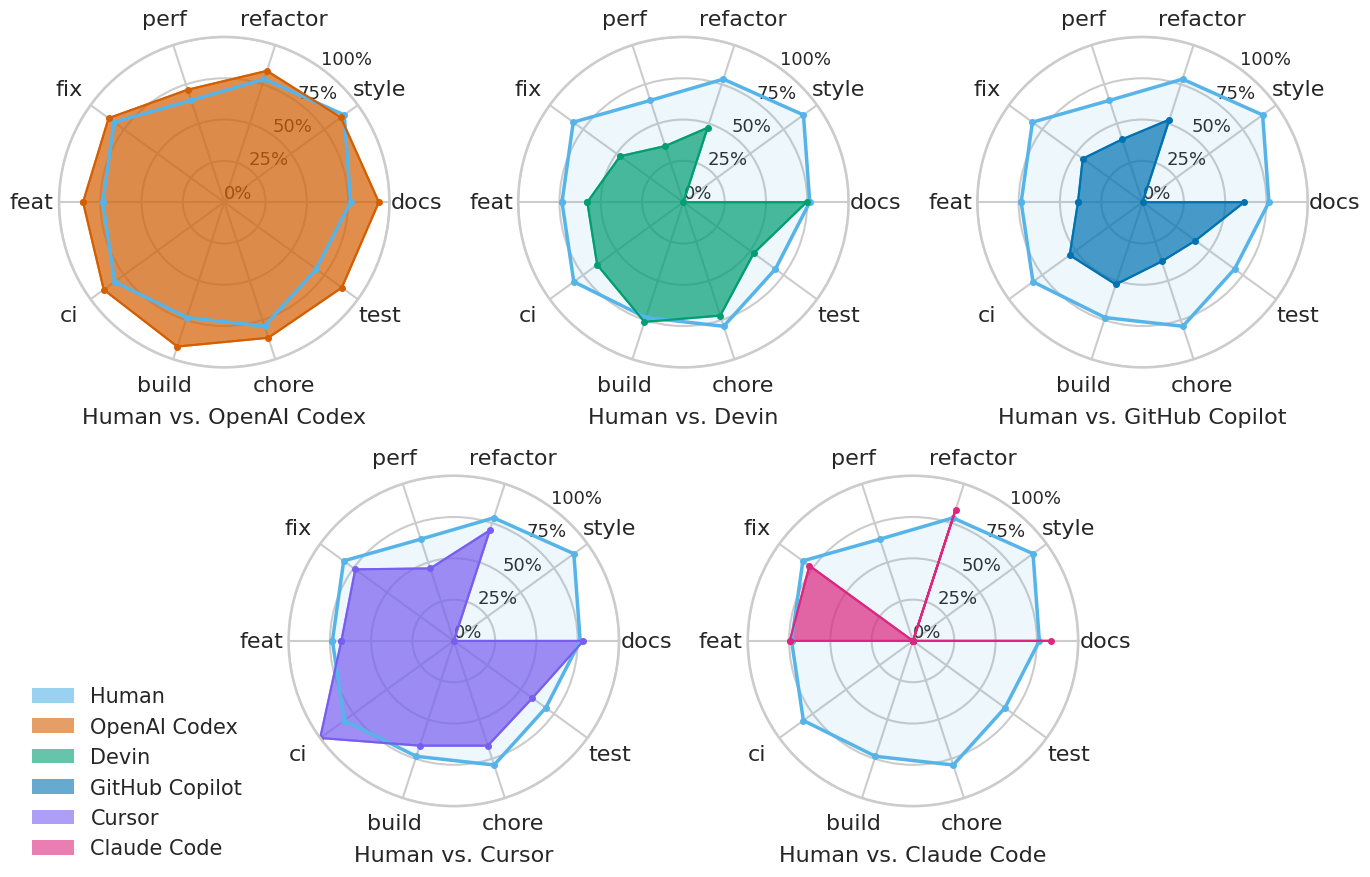

✓ wrote:
  • figs/pr_merge_compare_radar_100to500stars.pdf
  • figs/pr_merge_compare_radar_100to500stars.png


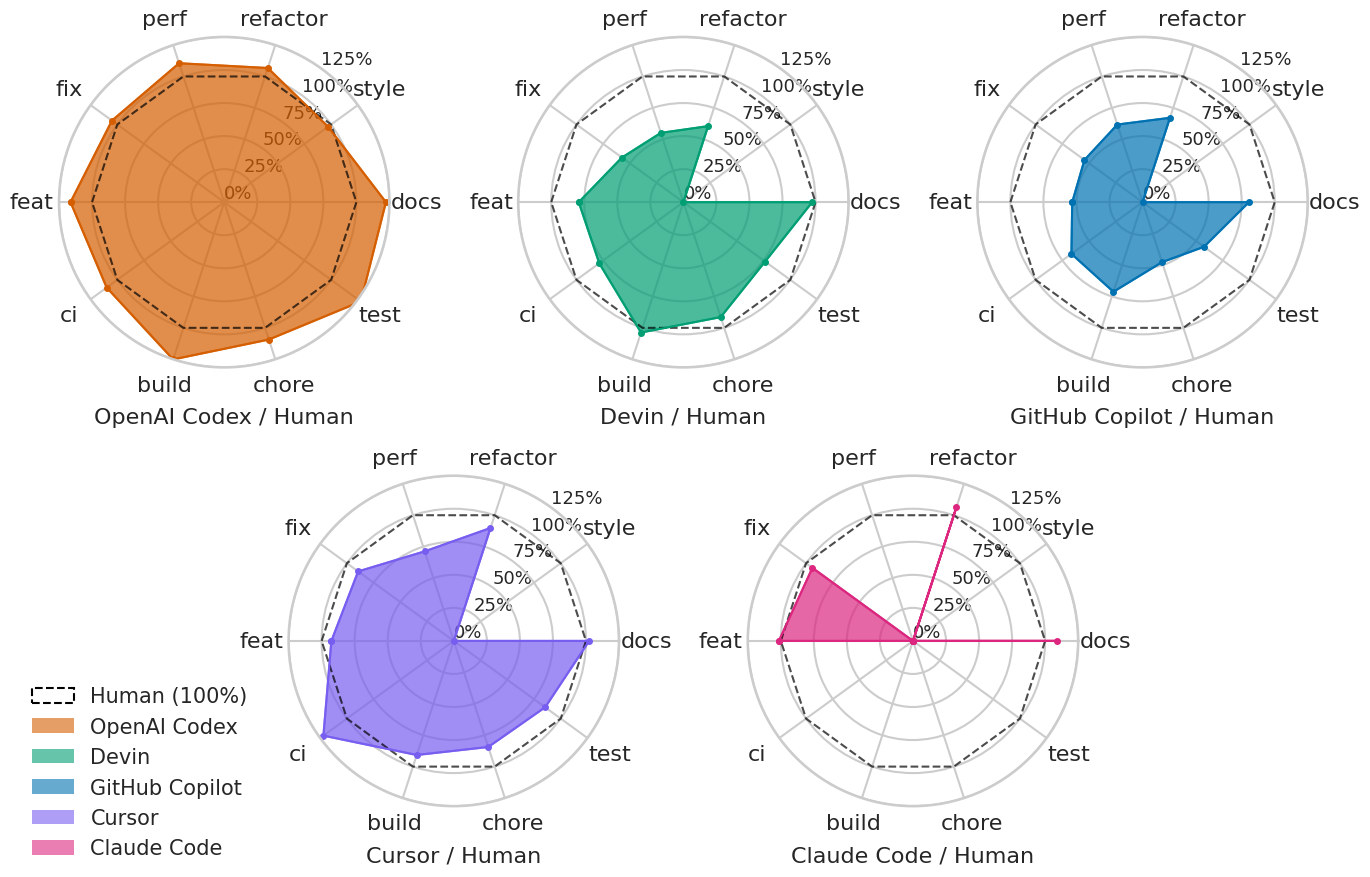

✓ wrote:
  • figs/pr_merge_compare_radar2_100to500stars.pdf
  • figs/pr_merge_compare_radar2_100to500stars.png
Human (Accept): count    5081.000000
mean       63.498462
std       206.833777
min         0.000556
25%         0.411389
50%         3.892778
75%        30.599722
max      3220.455278
Name: turnaround_hours, dtype: float64
Human (Reject): count    1068.000000
mean      233.190097
std       488.981769
min         0.000278
25%         1.241042
50%        27.554722
75%       190.819236
max      3815.923333
Name: turnaround_hours, dtype: float64
OpenAI_Codex (Accept): count    15170.000000
mean         4.274026
std         45.411097
min          0.001389
25%          0.003889
50%          0.008611
75%          0.057500
max       1494.180278
Name: turnaround_hours, dtype: float64
OpenAI_Codex (Reject): count    1834.000000
mean       42.235342
std       149.108032
min         0.000833
25%         0.016667
50%         0.428194
75%        15.201597
max      1548.445278
Name: turnarou

/tmp/ipython-input-3121000326.py:621: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([NAME_MAPPING.get(lbl.get_text(), lbl.get_text())


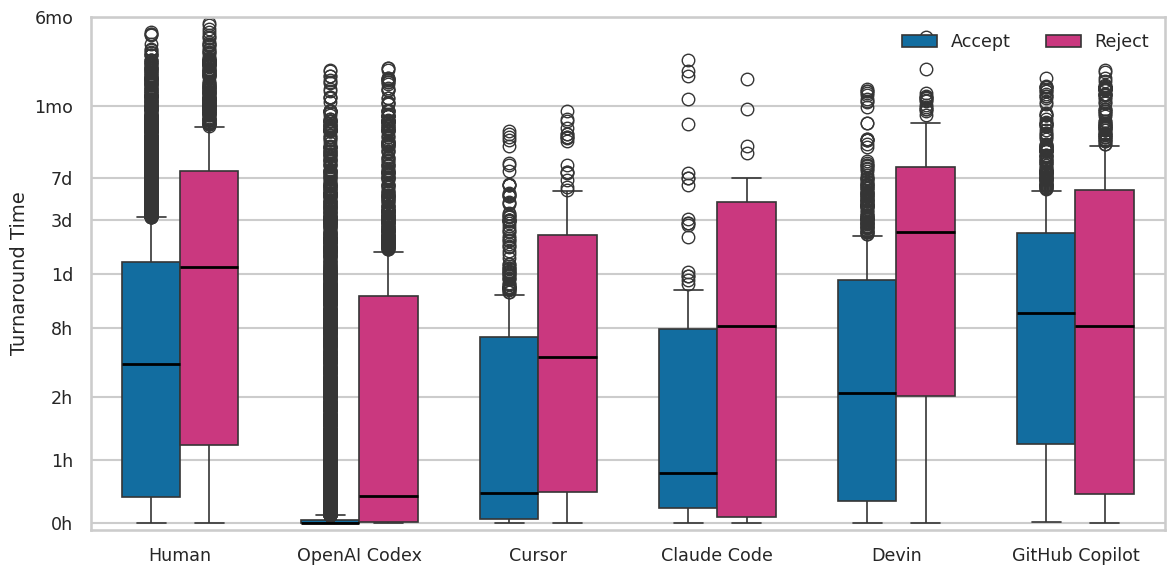

Wrote figs/turnaround_distribution_100to500stars.pdf
Wrote figs/turnaround_distribution_100to500stars.png
Baseline turnaround hours:
count    5081.000000
mean       63.498462
std       206.833777
min         0.000556
25%         0.411389
50%         3.892778
75%        30.599722
max      3220.455278
dtype: float64
Cliff's delta: small, d=-0.22876213846327786
Mann-Whitney-U-test: u=276265.5 p=3.475392483203254e-06
 Claude_Code Accept → Cliff size: small p-value: 3.475392483203254e-06
Sample turnaround hours:
count     141.000000
mean       51.669533
std       234.644967
min         0.001667
25%         0.234722
50%         0.788889
75%         7.817778
max      1797.698333
Name: turnaround_hours, dtype: float64
Cliff's delta: small, d=0.17367562505691897
Mann-Whitney-U-test: u=2120005.0 p=5.822381449306781e-14
 Copilot Accept → Cliff size: small p-value: 5.822381449306781e-14
Sample turnaround hours:
count     711.000000
mean       70.669229
std       161.571727
min         0.018333
25%

In [ ]:
# Load unified data once and pass it everywhere
data = load_hf_data(stars_range=[100, 500], include_repo=True)

agents = get_agents(data)

for ag in agents:
    summ = analyze_agent(ag, data)
    if summ.empty:
        print(f"No labelled PRs for {ag}")
        continue
    print(f"\n=== {ag} ===")
    print(summ[["total", "merged_pct"]].to_string(float_format="%.2f"))

# Radar (multi-panel, Human baseline if present)
merged_df = gather_merged_pct(agents, data)
plot_merged_pct_radar(
    merged_df,
    FIG_DIR / "pr_merge_compare_radar_100to500stars.pdf"
)

# Radar v2 (relative to Human when present)
plot_merged_pct_radar2(
    merged_df,
    FIG_DIR / "pr_merge_compare_radar2_100to500stars.pdf"
)

# Turnaround box
dist = gather_turnaround_distribution(agents, data)
plot_turnaround_box(
    dist,
    FIG_DIR / "turnaround_distribution_100to500stars.pdf",
    log_scale=True,
)

# Enhanced table
table_df = build_enhanced_table(agents, dist, data)
save_enhanced_table(table_df, FIG_DIR / "turnaround_enhanced_500stars.csv")

### 500 stars

/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut


=== Claude_Code ===
          total  merged_pct
type                       
feat     136.00       41.91
fix       75.00       46.67
refactor  20.00       40.00
docs      20.00       70.00
chore     13.00       69.23
test       5.00       40.00
build      4.00      100.00
perf       2.00       50.00
ci         1.00        0.00

=== Copilot ===
           total  merged_pct
type                        
fix      1449.00       41.48
feat     1058.00       37.33
docs      294.00       60.20
refactor  223.00       46.19
test      119.00       35.29
build      79.00       48.10
chore      65.00       49.23
ci         34.00       70.59
perf       34.00       23.53
style      13.00       38.46
other       7.00        0.00
revert      3.00      100.00

=== Cursor ===
          total  merged_pct
type                       
feat     378.00       55.56
fix      274.00       65.69
docs      96.00       69.79
refactor  57.00       59.65
chore     35.00       77.14
build     24.00       50.00
test    

/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)



=== Devin ===
           total  merged_pct
type                        
feat     1311.00       52.63
fix       966.00       41.61
docs      400.00       69.50
refactor  361.00       58.73
chore     227.00       52.86
test       79.00       49.37
perf       48.00       35.42
build      43.00       48.84
ci         28.00       57.14
style      22.00       72.73
revert      4.00       50.00
other       3.00        0.00

=== Human ===
           total  merged_pct
type                        
feat     1946.00       73.48
fix      1778.00       82.40
chore     847.00       78.98
build     614.00       73.45
docs      519.00       76.49
refactor  369.00       78.32
test      183.00       68.85
other     115.00       53.91
ci        100.00       82.00
perf       88.00       64.77
style      59.00       89.83


/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)



=== OpenAI_Codex ===
           total  merged_pct
type                        
feat     1379.00       51.12
fix      1284.00       69.86
docs      668.00       88.17
test      336.00       62.80
refactor  310.00       66.13
chore     147.00       78.23
build      71.00       64.79
ci         51.00       70.59
perf       31.00       48.39
style      20.00       70.00
other       4.00        0.00
revert      1.00      100.00


/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = (df.groupby("type").apply(summarise)
/tmp/ipython-input-3121000326.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut

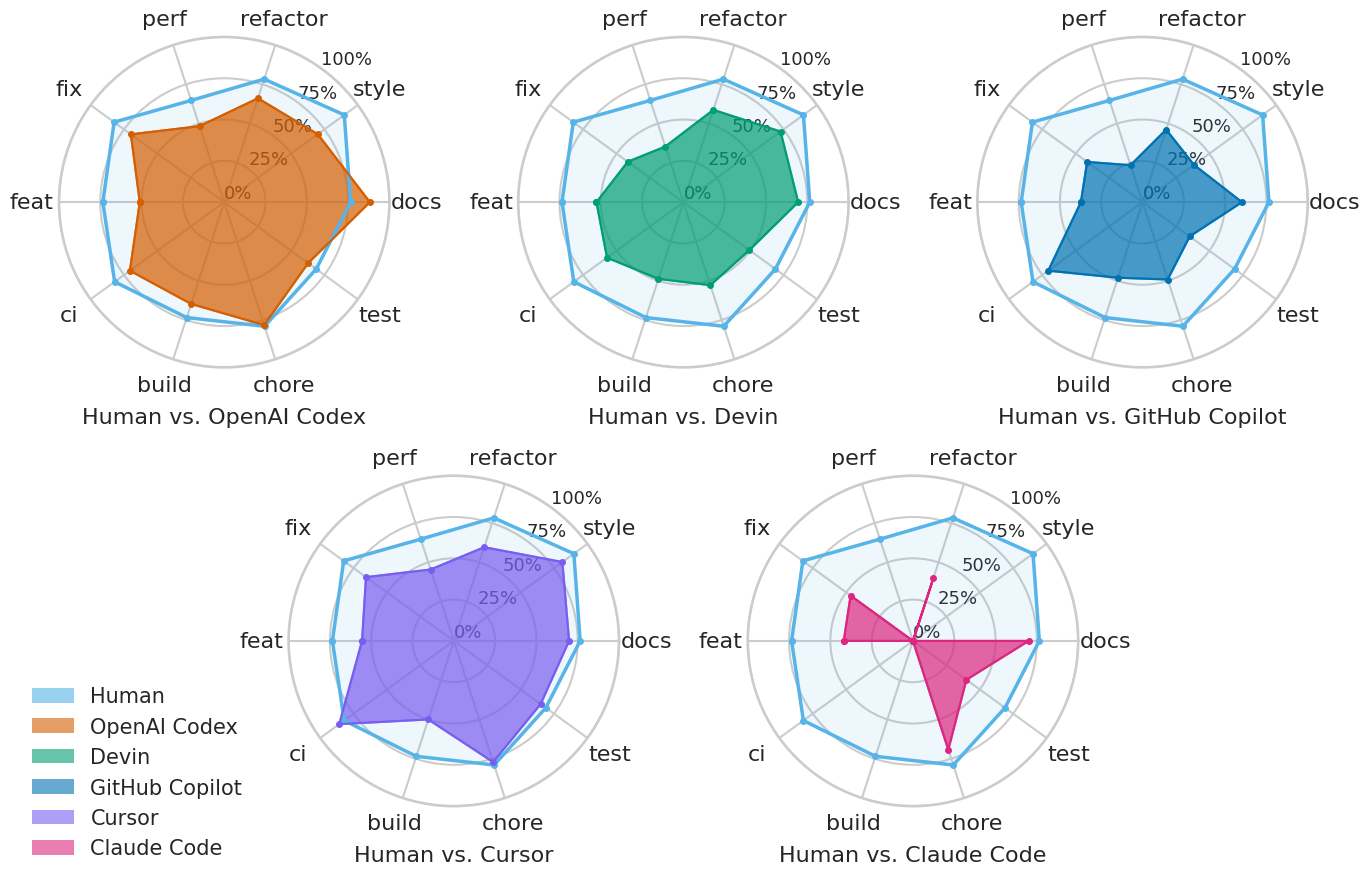

✓ wrote:
  • figs/pr_merge_compare_radar_500stars.pdf
  • figs/pr_merge_compare_radar_500stars.png


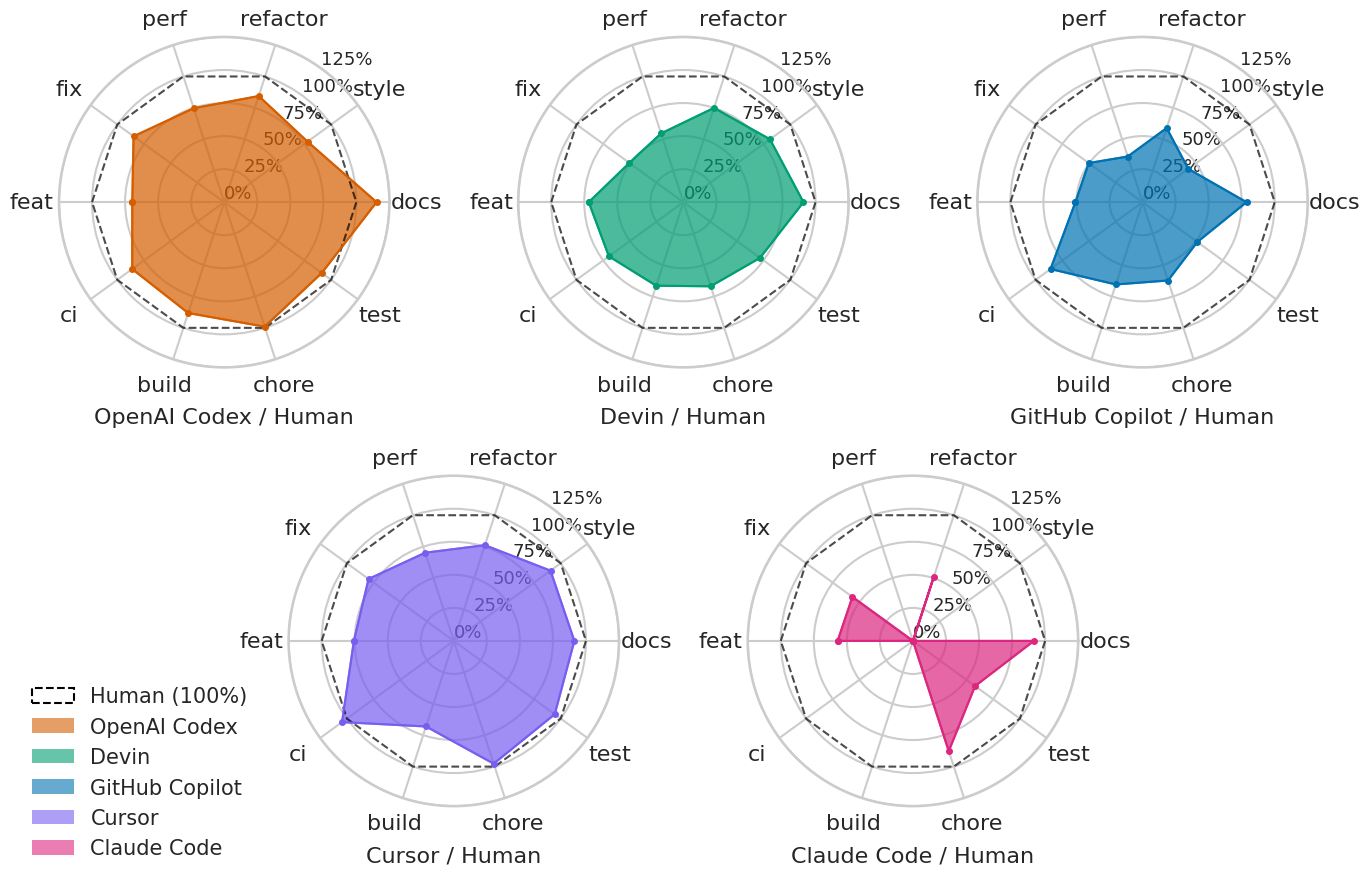

✓ wrote:
  • figs/pr_merge_compare_radar2_500stars.pdf
  • figs/pr_merge_compare_radar2_500stars.png
Human (Accept): count    5081.000000
mean       63.498462
std       206.833777
min         0.000556
25%         0.411389
50%         3.892778
75%        30.599722
max      3220.455278
Name: turnaround_hours, dtype: float64
Human (Reject): count    1068.000000
mean      233.190097
std       488.981769
min         0.000278
25%         1.241042
50%        27.554722
75%       190.819236
max      3815.923333
Name: turnaround_hours, dtype: float64
OpenAI_Codex (Accept): count    2834.000000
mean       32.535051
std       119.679727
min         0.001389
25%         0.043333
50%         0.336806
75%         9.308056
max      1776.576944
Name: turnaround_hours, dtype: float64
OpenAI_Codex (Reject): count    1155.000000
mean      149.859641
std       314.387423
min         0.001111
25%         0.466250
50%        14.821111
75%       116.066250
max      1620.089722
Name: turnaround_hours, dtype: f

/tmp/ipython-input-3121000326.py:621: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([NAME_MAPPING.get(lbl.get_text(), lbl.get_text())


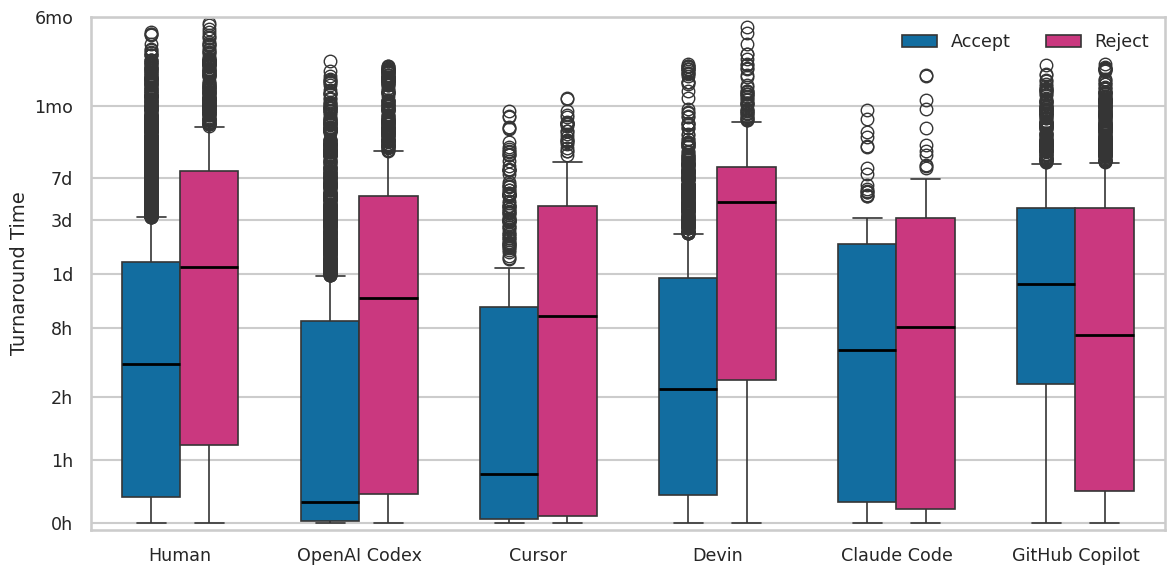

Wrote figs/turnaround_distribution_500stars.pdf
Wrote figs/turnaround_distribution_500stars.png
Baseline turnaround hours:
count    5081.000000
mean       63.498462
std       206.833777
min         0.000556
25%         0.411389
50%         3.892778
75%        30.599722
max      3220.455278
dtype: float64
Cliff's delta: negligible, d=-0.015160552889346434
Mann-Whitney-U-test: u=325258.0 p=0.767550128571227
 Claude_Code Accept → Cliff size: negligible p-value: 0.767550128571227
Sample turnaround hours:
count    130.000000
mean      42.915650
std       99.965597
min        0.003333
25%        0.329375
50%        5.136528
75%       44.054306
max      663.741667
Name: turnaround_hours, dtype: float64
Cliff's delta: small, d=0.28322106248521844
Mann-Whitney-U-test: u=4655313.0 p=2.7920265356690554e-60
 Copilot Accept → Cliff size: small p-value: 2.7920265356690554e-60
Sample turnaround hours:
count    1428.000000
mean       85.244785
std       172.011530
min         0.009444
25%         2.60

In [ ]:
# Load unified data once and pass it everywhere
data = load_hf_data(stars_range=[500, None], include_repo=True)

agents = get_agents(data)

for ag in agents:
    summ = analyze_agent(ag, data)
    if summ.empty:
        print(f"No labelled PRs for {ag}")
        continue
    print(f"\n=== {ag} ===")
    print(summ[["total", "merged_pct"]].to_string(float_format="%.2f"))

# Radar (multi-panel, Human baseline if present)
merged_df = gather_merged_pct(agents, data)
plot_merged_pct_radar(
    merged_df,
    FIG_DIR / "pr_merge_compare_radar_500stars.pdf"
)

# Radar v2 (relative to Human when present)
plot_merged_pct_radar2(
    merged_df,
    FIG_DIR / "pr_merge_compare_radar2_500stars.pdf"
)

# Turnaround box
dist = gather_turnaround_distribution(agents, data)
plot_turnaround_box(
    dist,
    FIG_DIR / "turnaround_distribution_500stars.pdf",
    log_scale=True,
)

# Enhanced table
table_df = build_enhanced_table(agents, dist, data)
save_enhanced_table(table_df, FIG_DIR / "turnaround_enhanced_500stars.csv")

✅ Libraries and settings loaded successfully!
📁 Output directory: /content/figs
✅ Data loading functions ready!
✅ Review analysis functions ready!
✅ Visualization functions ready!
✅ Statistical summary functions ready!
✅ Main execution pipeline ready!

████████████████████████████████████████████████████████████████████████████████
█                                                                              █
█                    REVIEW ASPECTS ANALYSIS                                   █
█               Agentic-PRs on GitHub (AIDev Dataset)                            █
█                                                                              █
████████████████████████████████████████████████████████████████████████████████

🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
STEP 1: LOADING DATA
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

📦 LOADING AIDEV DATASET
⏳ Loading AI PRs...
⏳ Loading Human PRs...
⏳ Loading labels...
🔍 Filtering repos with 500+ stars...
✓ Filtered to 1,479 repositori

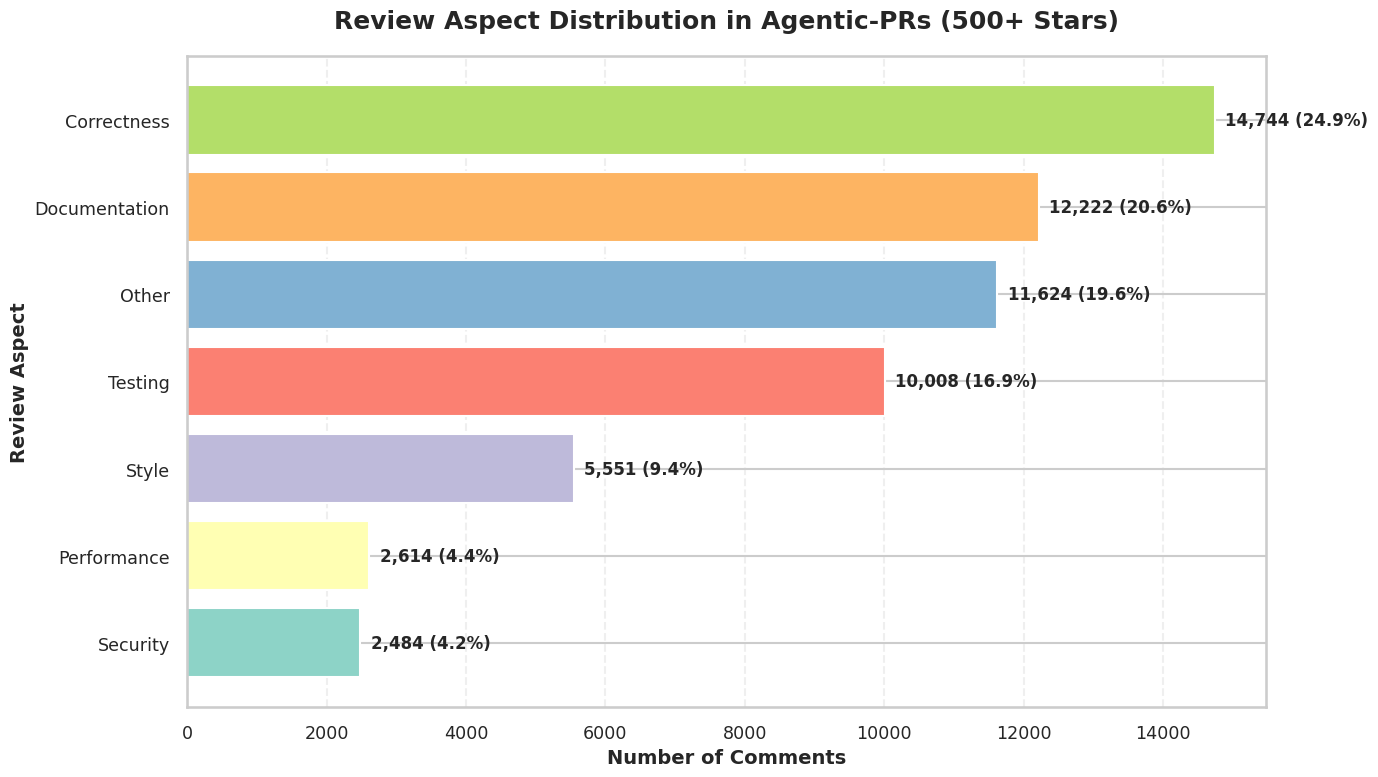

   ✓ Saved: 1_overall_distribution.png/pdf

2️⃣  Creating heatmap...


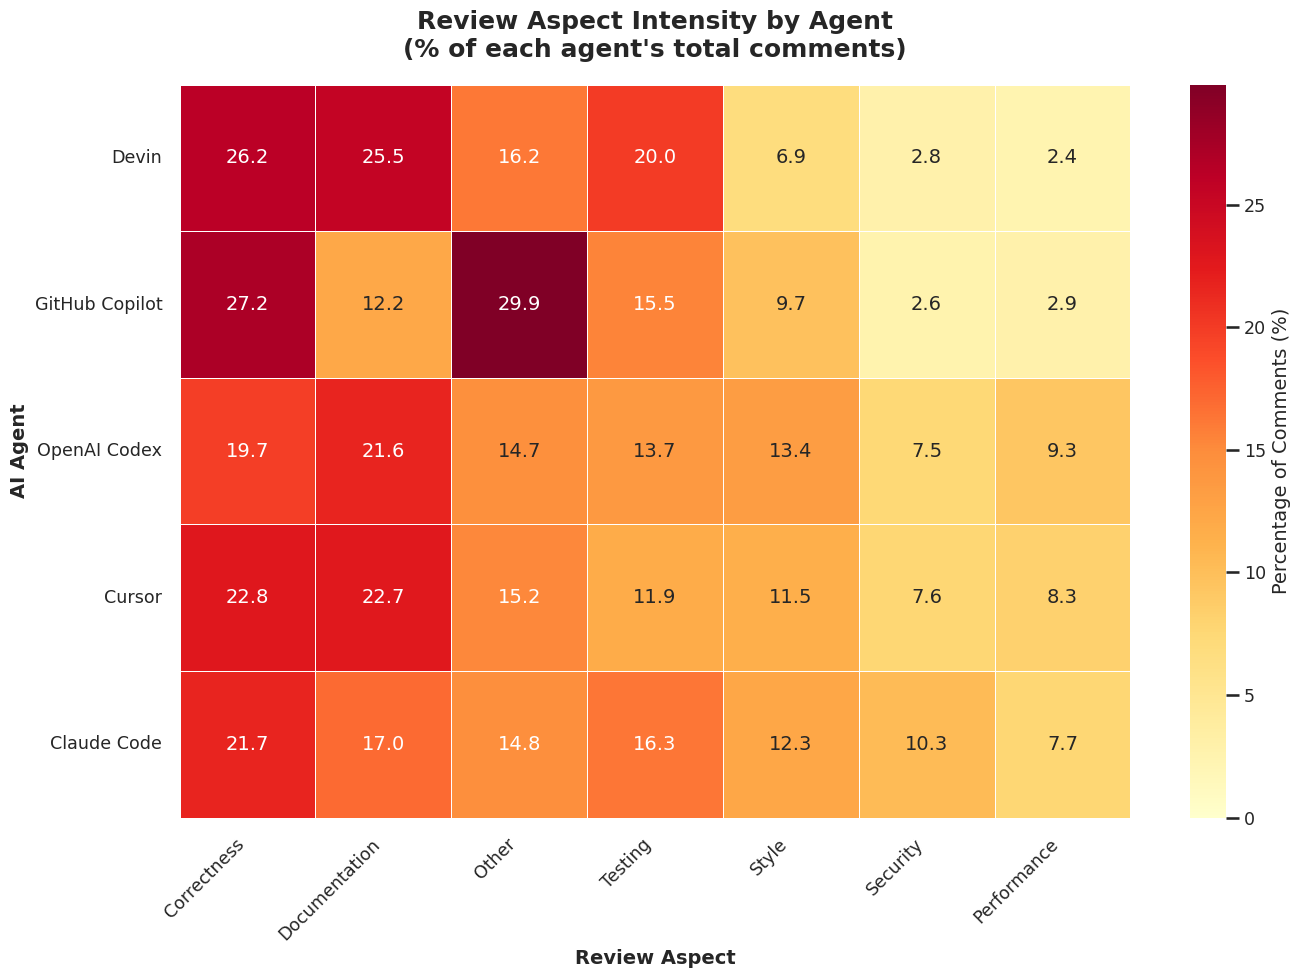

   ✓ Saved: 2_heatmap_by_agent.png/pdf

3️⃣  Creating stacked bar chart...


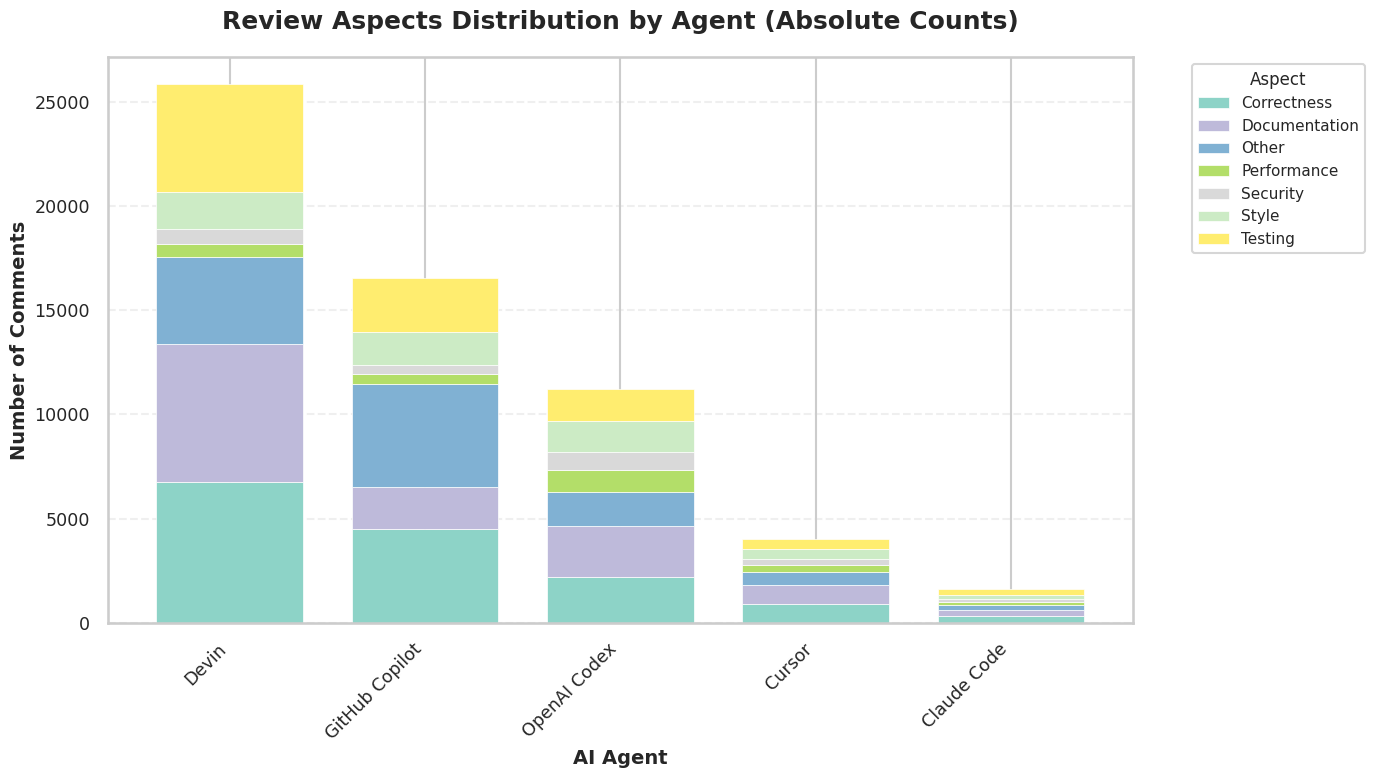

   ✓ Saved: 3_stacked_by_agent.png/pdf

5️⃣  Creating radar chart...


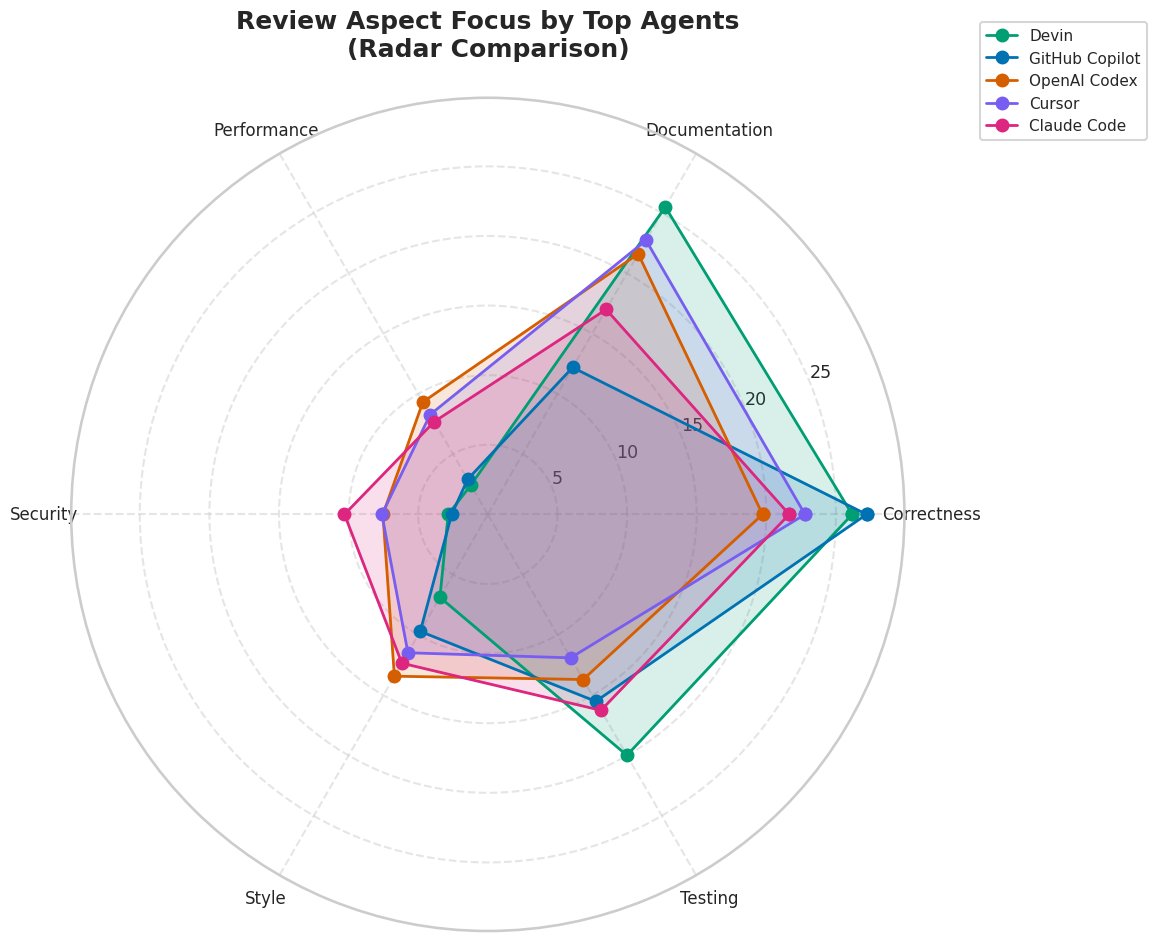

   ✓ Saved: 5_radar_comparison.png/pdf

6️⃣  Creating pie chart...


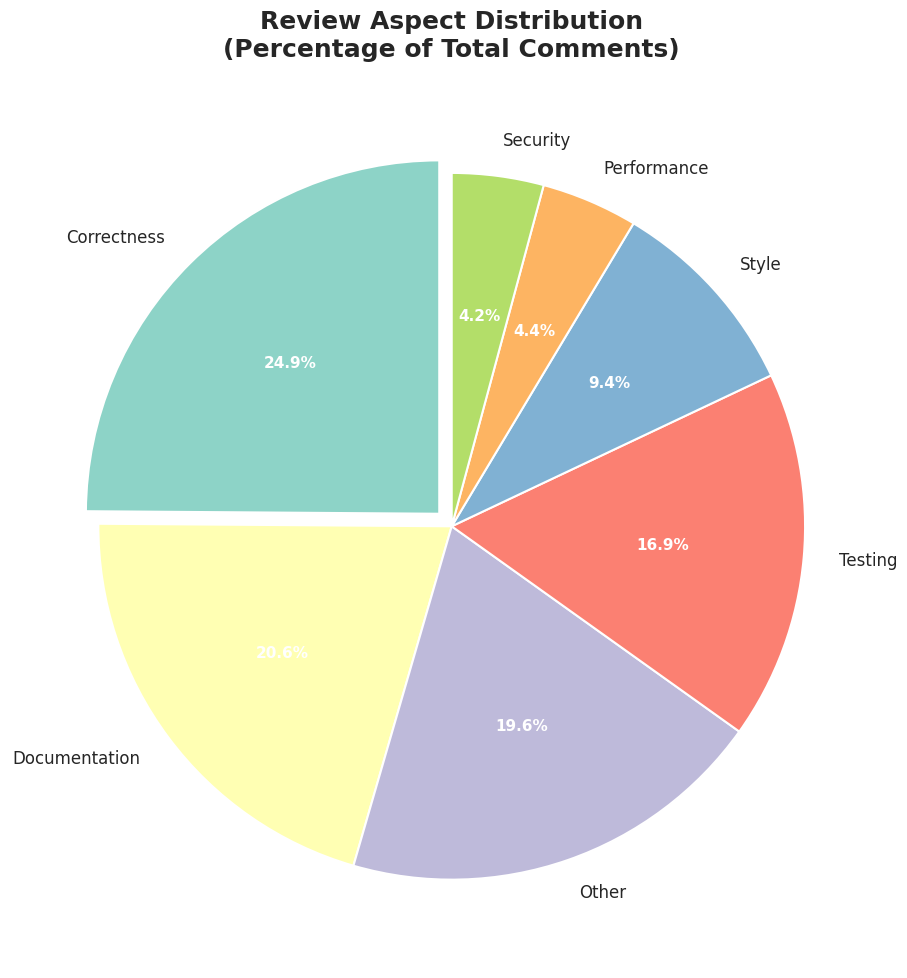

   ✓ Saved: 6_pie_distribution.png/pdf

✅ ALL VISUALIZATIONS CREATED SUCCESSFULLY!
📁 Saved to: /content/figs/review_aspects_500plus

🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
STEP 8: GENERATING SUMMARY
🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹

📊 GENERATING STATISTICAL SUMMARY
REVIEW ASPECTS ANALYSIS - STATISTICAL SUMMARY
Dataset: AIDev (Repositories with 500+ GitHub Stars)

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total Comments Analyzed: 59,247
Total Comment-Aspect Pairs: 59,247
Unique PRs: 8,909
Agents Analyzed: 5

Comment Distribution by Source:
  - AI: 59,247 (100.0%)

Comment Distribution by Type:
  - discussion: 49,020 (82.7%)
  - review_verdict: 10,227 (17.3%)

2. TOP REVIEW ASPECTS
--------------------------------------------------------------------------------
 1. Correctness         :  14,744 ( 24.9%)
 2. Documentation       :  12,222 ( 20.6%)
 3. Other               :  11,624 ( 19.6%)
 4. Testing             :  10,00

In [24]:
# =============================================================================
# CELL 1: Libraries and Setup
# =============================================================================

from __future__ import annotations

# Install required packages
!pip install -q cliffs-delta

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from scipy import stats
from cliffs_delta import cliffs_delta
import re
import warnings
from pathlib import Path
from dataclasses import dataclass
from typing import Iterable, List, Dict, Any, Tuple
import math

warnings.filterwarnings('ignore')

# Visualization settings
FONT_SCALE = 1.4
_BASE_FONT = 10

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=FONT_SCALE)

plt.rcParams.update({
    "font.size": _BASE_FONT * FONT_SCALE,
    "axes.titlesize": _BASE_FONT * FONT_SCALE * 1.2,
    "axes.labelsize": _BASE_FONT * FONT_SCALE,
    "xtick.labelsize": _BASE_FONT * FONT_SCALE * 0.9,
    "ytick.labelsize": _BASE_FONT * FONT_SCALE * 0.9,
    "legend.fontsize": _BASE_FONT * FONT_SCALE * 0.9,
    "figure.figsize": (14, 8),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
})

# Constants
SECONDS_TO_HOUR = 3600
SECONDS_TO_DAY = 86_400

# Directory setup
FIG_DIR = Path("figs")
FIG_DIR.mkdir(exist_ok=True)

# Color mapping for agents
COLOR_MAP = {
    "Human": "#56B4E9",
    "OpenAI_Codex": "#D55E00",
    "OpenAI Codex": "#D55E00",
    "Codex": "#D55E00",
    "Devin": "#009E73",
    "Copilot": "#0072B2",
    "GitHub Copilot": "#0072B2",
    "Cursor": "#785EF0",
    "Claude_Code": "#DC267F",
    "Claude Code": "#DC267F",
}

# Name mapping
NAME_MAPPING = {
    "OpenAI_Codex": "OpenAI Codex",
    "Codex": "OpenAI Codex",
    "Devin": "Devin",
    "Copilot": "GitHub Copilot",
    "Cursor": "Cursor",
    "Claude_Code": "Claude Code",
    "Claude": "Claude Code",
    "Human": "Human",
    "OpenAI Codex": "OpenAI Codex",
    "GitHub Copilot": "GitHub Copilot",
    "Claude Code": "Claude Code",
}

# Add missing colors
for key, value in NAME_MAPPING.items():
    if key not in COLOR_MAP:
        COLOR_MAP[key] = COLOR_MAP[value]

print("✅ Libraries and settings loaded successfully!")
print(f"📁 Output directory: {FIG_DIR.absolute()}")


# =============================================================================
# CELL 2: Data Structures and Core Loading Functions
# =============================================================================

# Hugging Face dataset paths
HF_PR_PATH = "hf://datasets/hao-li/AIDev/pull_request.parquet"
HF_REPO_PATH = "hf://datasets/hao-li/AIDev/repository.parquet"
HF_LABEL_PATH = "hf://datasets/hao-li/AIDev/pr_task_type.parquet"
HF_HUMAN_PR_PATH = "hf://datasets/hao-li/AIDev/human_pull_request.parquet"
HF_HUMAN_LABEL_PATH = "hf://datasets/hao-li/AIDev/human_pr_task_type.parquet"

# Review data paths
HF_PR_COMMENTS = "hf://datasets/hao-li/AIDev/pr_comments.parquet"
HF_PR_REVIEW_COMMENTS = "hf://datasets/hao-li/AIDev/pr_review_comments.parquet"
HF_PR_REVIEWS = "hf://datasets/hao-li/AIDev/pr_reviews.parquet"


@dataclass(frozen=True)
class HFData:
    """Container for all loaded dataframes."""
    pr_df: pd.DataFrame
    lbl_df: pd.DataFrame
    repo_df: pd.DataFrame | None


def _read_parquet_safely(path: str) -> pd.DataFrame:
    """Read parquet file safely."""
    return pd.read_parquet(path)


def load_hf_data(*,
                 stars_range: list[float | int | None] | tuple[float | int | None, float | int | None] | None = None,
                 include_repo: bool = False) -> HFData:
    """
    Load PRs + labels (AI + Human), optionally filter by repo stars range.

    Args:
        stars_range: [lower_bound, upper_bound] for star filtering
        include_repo: Whether to load repository data

    Returns:
        HFData object with pr_df, lbl_df, and optionally repo_df
    """
    print("\n" + "="*80)
    print("📦 LOADING AIDEV DATASET")
    print("="*80)

    # Load AI PRs
    print("⏳ Loading AI PRs...")
    pr_ai = _read_parquet_safely(HF_PR_PATH)
    pr_ai['source'] = 'AI'

    # Load Human PRs
    print("⏳ Loading Human PRs...")
    pr_human = _read_parquet_safely(HF_HUMAN_PR_PATH)
    pr_human['source'] = 'Human'

    # Convert datetime columns
    for df in (pr_ai, pr_human):
        for col in ["created_at", "closed_at", "merged_at"]:
            if col in df.columns and df[col].dtype != "datetime64[ns, UTC]":
                df[col] = pd.to_datetime(df[col], utc=True, errors="coerce")

    # Load labels
    print("⏳ Loading labels...")
    lbl_ai = _read_parquet_safely(HF_LABEL_PATH)
    lbl_ai['source'] = 'AI'

    lbl_human = _read_parquet_safely(HF_HUMAN_LABEL_PATH)
    lbl_human['source'] = 'Human'

    for df in (lbl_ai, lbl_human):
        if "type" in df.columns:
            df["type"] = df["type"].astype(str).str.strip()

    repo_df: pd.DataFrame | None = None

    # Star filtering
    if stars_range is not None:
        if not (isinstance(stars_range, (list, tuple)) and len(stars_range) == 2):
            raise ValueError("stars_range must be [lower, upper]")

        lower_bound, upper_bound = stars_range
        print(f"🔍 Filtering repos with {lower_bound}+ stars...")

        repo_df = _read_parquet_safely(HF_REPO_PATH)

        if "url" in repo_df.columns and "stars" in repo_df.columns:
            mask = repo_df["url"].notna()
            if lower_bound is not None:
                mask &= repo_df["stars"] >= lower_bound
            if upper_bound is not None:
                mask &= repo_df["stars"] <= upper_bound

            good_repo_urls = set(repo_df.loc[mask, "url"].astype(str).unique())

            # Filter AI PRs
            if "repo_url" in pr_ai.columns:
                pr_ai = pr_ai[pr_ai["repo_url"].astype(str).isin(good_repo_urls)].copy()

            # Filter Human PRs
            if "repo_url" in pr_human.columns:
                pr_human = pr_human[pr_human["repo_url"].astype(str).isin(good_repo_urls)].copy()

            # Filter labels
            if "id" in lbl_ai.columns and "id" in pr_ai.columns:
                keep_ids_ai = set(pr_ai["id"].unique())
                lbl_ai = lbl_ai[lbl_ai["id"].isin(keep_ids_ai)].copy()

            if "id" in lbl_human.columns and "id" in pr_human.columns:
                keep_ids_human = set(pr_human["id"].unique())
                lbl_human = lbl_human[lbl_human["id"].isin(keep_ids_human)].copy()

            print(f"✓ Filtered to {len(repo_df[mask]):,} repositories")

    elif include_repo:
        repo_df = _read_parquet_safely(HF_REPO_PATH)

    # Combine AI + Human
    pr_all = pd.concat([pr_ai, pr_human], ignore_index=True)
    lbl_all = pd.concat([lbl_ai, lbl_human], ignore_index=True)

    print(f"\n✓ Loaded {len(pr_all):,} total PRs")
    print(f"  - AI PRs: {len(pr_ai):,}")
    print(f"  - Human PRs: {len(pr_human):,}")
    print(f"✓ Loaded {len(lbl_all):,} labels")
    if repo_df is not None:
        print(f"✓ Loaded {len(repo_df):,} repositories")

    return HFData(pr_df=pr_all, lbl_df=lbl_all, repo_df=repo_df)


print("✅ Data loading functions ready!")

# =============================================================================
# CELL 3: Review Comments Analysis Functions
# =============================================================================

# Aspect categorization keywords
ASPECT_KEYWORDS = {
    'correctness': [
        r'\bbug\b', r'\berror\b', r'\bwrong\b', r'\bincorrect\b', r'\bfail',
        r'\bfix\b', r'\bissue\b', r'\bproblem\b', r'\bbroken\b', r'\bcrash',
        r'\bexception\b', r'\bdefect\b', r'\bflaw\b', r'\blogic.*error\b',
        r'\bnot\s+work', r'\bdoesn\'?t\s+work\b', r'\bshould\s+be\b',
        r'\bmistake\b', r'\binvalid\b', r'\bbreaks\b'
    ],
    'style': [
        r'\bformat', r'\bstyle\b', r'\bindent', r'\bwhitespace\b', r'\bnaming\b',
        r'\breadab', r'\bclean', r'\bconsistent', r'\bconvention\b', r'\blint',
        r'\bpep\s*8\b', r'\bprettier\b', r'\beslint\b', r'\bcode\s+style\b',
        r'\bformatting\b', r'\bspacing\b', r'\brefactor\b'
    ],
    'security': [
        r'\bsecur', r'\bvulner', r'\bauthen', r'\bauthor', r'\bsanitiz',
        r'\binjection\b', r'\bxss\b', r'\bcsrf\b', r'\bsql.*injection\b',
        r'\bpassword\b', r'\btoken\b', r'\bencrypt', r'\bprivacy\b', r'\bleak',
        r'\bpermission\b', r'\baccess\s+control\b', r'\bexploit\b'
    ],
    'testing': [
        r'\btest\b', r'\bcoverage\b', r'\bunit\s+test\b', r'\bintegration\s+test\b',
        r'\be2e\b', r'\bmock\b', r'\bassertion\b', r'\bedge\s+case\b',
        r'\btest\s+case\b', r'\bci\b', r'\bfailing\s+test\b', r'\bshould\s+test\b',
        r'\btest\s+suite\b'
    ],
    'performance': [
        r'\bperformance\b', r'\boptimiz', r'\bslow\b', r'\bfast', r'\beffic',
        r'\bmemory\b', r'\bcpu\b', r'\bscale', r'\btimeout\b', r'\bcache',
        r'\blatency\b', r'\bthroughput\b', r'\bbottleneck\b', r'\bO\([nN]\)',
        r'\bspeed\b'
    ],
    'documentation': [
        r'\bdoc\b', r'\bcomment\b', r'\bexplain', r'\bdocstring\b', r'\breadme\b',
        r'\bjavadoc\b', r'\bjsdoc\b', r'\bannotation\b', r'\bdescri', r'\bclarif',
        r'\bdocumentation\b', r'\badd\s+comment\b', r'\bunclear\b'
    ]
}


def load_review_data(data: HFData) -> dict:
    """Load all review-related data with proper column detection."""
    print("\n" + "="*80)
    print("💬 LOADING REVIEW COMMENTS DATA")
    print("="*80)

    # Load all review data
    print("⏳ Loading comment files...")
    pr_comments = pd.read_parquet(HF_PR_COMMENTS)
    pr_review_comments = pd.read_parquet(HF_PR_REVIEW_COMMENTS)
    pr_reviews = pd.read_parquet(HF_PR_REVIEWS)

    print(f"✓ Loaded {len(pr_comments):,} discussion comments")
    print(f"✓ Loaded {len(pr_review_comments):,} inline review comments")
    print(f"✓ Loaded {len(pr_reviews):,} review verdicts")

    # Get PR IDs from our filtered dataset
    pr_ids = set(data.pr_df['id'].unique())
    print(f"\n🎯 Filtering for {len(pr_ids):,} PRs in our dataset...")

    # Detect PR ID column for each dataframe
    def detect_and_filter(df, name):
        """Detect PR ID column and filter."""
        # Check each possible column
        pr_id_col = None

        # Print available columns for debugging
        print(f"\n🔍 {name} columns: {df.columns.tolist()}")

        # Try to find the PR ID column
        for possible in ['pr_id', 'pull_request_id', 'pr_number']:
            if possible in df.columns:
                pr_id_col = possible
                print(f"   → Using '{pr_id_col}' as PR ID")
                break

        if pr_id_col is None:
            print(f"   ⚠️  No standard PR ID column found. Trying alternatives...")
            # Look for columns with PR-like values
            for col in df.columns:
                if col != 'id' and df[col].dtype in ['int64', 'Int64']:
                    # Check if values overlap with our PR IDs
                    overlap = set(df[col].dropna().unique()) & pr_ids
                    if len(overlap) > 0:
                        pr_id_col = col
                        print(f"   → Found match in '{col}' ({len(overlap):,} matching PRs)")
                        break

        if pr_id_col is None:
            print(f"   ❌ Could not find PR ID column!")
            return df.iloc[0:0].copy()  # Return empty dataframe

        # Filter
        filtered = df[df[pr_id_col].isin(pr_ids)].copy()

        # Rename to standard 'pr_id'
        if pr_id_col != 'pr_id':
            filtered.rename(columns={pr_id_col: 'pr_id'}, inplace=True)

        print(f"   ✓ Filtered to {len(filtered):,} comments")
        return filtered

    # Filter each dataframe
    pr_comments_filtered = detect_and_filter(pr_comments, "pr_comments")
    pr_review_comments_filtered = detect_and_filter(pr_review_comments, "pr_review_comments")
    pr_reviews_filtered = detect_and_filter(pr_reviews, "pr_reviews")

    print(f"\n{'='*80}")
    print("✓ FILTERING COMPLETE")
    print(f"  - Discussion comments: {len(pr_comments_filtered):,}")
    print(f"  - Inline comments: {len(pr_review_comments_filtered):,}")
    print(f"  - Reviews: {len(pr_reviews_filtered):,}")
    print(f"  - Total: {len(pr_comments_filtered) + len(pr_review_comments_filtered) + len(pr_reviews_filtered):,}")

    return {
        'pr_comments': pr_comments_filtered,
        'pr_review_comments': pr_review_comments_filtered,
        'pr_reviews': pr_reviews_filtered
    }


def prepare_comments_for_analysis(review_data: dict, data: HFData) -> pd.DataFrame:
    """Combine all comment types and add agent/source information."""
    print("\n" + "="*80)
    print("🔗 PREPARING COMMENTS FOR ANALYSIS")
    print("="*80)

    # Create PR to agent/source mapping
    pr_info = data.pr_df[['id', 'agent', 'source']].copy()
    pr_info = pr_info.set_index('id')

    comments_list = []

    # Process each comment type
    comment_types = [
        ('pr_comments', 'discussion'),
        ('pr_review_comments', 'inline_review'),
        ('pr_reviews', 'review_verdict')
    ]

    for key, comment_type in comment_types:
        if key in review_data and not review_data[key].empty:
            df = review_data[key][['pr_id', 'body']].copy()
            df['comment_type'] = comment_type
            comments_list.append(df)
            print(f"✓ {len(df):,} {comment_type} comments")

    if not comments_list:
        raise ValueError("No comments found after filtering!")

    # Combine all comments
    all_comments = pd.concat(comments_list, ignore_index=True)

    # Add agent and source information
    all_comments = all_comments.merge(
        pr_info,
        left_on='pr_id',
        right_index=True,
        how='left'
    )

    # Remove empty comments
    all_comments = all_comments[all_comments['body'].notna()]
    all_comments = all_comments[all_comments['body'].str.strip() != '']

    # Remove comments without agent info (shouldn't happen, but just in case)
    all_comments = all_comments[all_comments['agent'].notna()]

    print(f"\n{'='*80}")
    print("✓ COMMENTS PREPARED")
    print(f"  Total comments: {len(all_comments):,}")
    print(f"\n  By Source:")
    print(all_comments['source'].value_counts().to_string())
    print(f"\n  By Agent:")
    print(all_comments['agent'].value_counts().to_string())
    print(f"\n  By Comment Type:")
    print(all_comments['comment_type'].value_counts().to_string())

    return all_comments


def categorize_comment(comment_text: str) -> list[str]:
    """Categorize a comment into aspects based on keyword matching."""
    if pd.isna(comment_text):
        return ['other']

    comment_lower = comment_text.lower()
    matched_aspects = []

    for aspect, keywords in ASPECT_KEYWORDS.items():
        for pattern in keywords:
            if re.search(pattern, comment_lower):
                matched_aspects.append(aspect)
                break  # One match per aspect

    return matched_aspects if matched_aspects else ['other']


def categorize_all_comments(comments_df: pd.DataFrame) -> pd.DataFrame:
    """Apply aspect categorization to all comments."""
    print("\n" + "="*80)
    print("🏷️  CATEGORIZING COMMENTS BY ASPECT")
    print("="*80)

    print("⏳ Analyzing comment text (this may take a minute)...")
    comments_df = comments_df.copy()
    comments_df['aspects'] = comments_df['body'].apply(categorize_comment)

    # Explode to have one row per aspect (comments can have multiple aspects)
    comments_exploded = comments_df.explode('aspects')
    comments_exploded = comments_exploded[comments_exploded['aspects'].notna()]

    print(f"✓ Categorized {len(comments_exploded):,} comment-aspect pairs")

    # Show distribution
    aspect_counts = comments_exploded['aspects'].value_counts()
    print(f"\n{'='*80}")
    print("📊 ASPECT DISTRIBUTION")
    print(f"{'='*80}")
    total = len(comments_exploded)
    for aspect, count in aspect_counts.items():
        percentage = (count / total) * 100
        bar = '█' * int(percentage / 2)
        print(f"  {aspect.capitalize():15s}: {count:6,} ({percentage:5.1f}%) {bar}")

    return comments_exploded


def analyze_aspects_by_agent(comments_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Analyze aspect distribution for each agent."""
    print("\n" + "="*80)
    print("📈 ANALYZING ASPECTS BY AGENT")
    print("="*80)

    # Create percentage distribution
    aspect_by_agent_pct = pd.crosstab(
        comments_df['agent'],
        comments_df['aspects'],
        normalize='index'
    ) * 100

    # Create raw counts
    aspect_by_agent_counts = pd.crosstab(
        comments_df['agent'],
        comments_df['aspects']
    )

    print("\n📊 Aspect Distribution by Agent (%):")
    print(aspect_by_agent_pct.round(1).to_string())

    print("\n📊 Raw Comment Counts by Agent:")
    print(aspect_by_agent_counts.to_string())

    # Chi-square test
    chi2, p_value, dof, expected = stats.chi2_contingency(aspect_by_agent_counts)

    print(f"\n{'='*80}")
    print("📊 STATISTICAL TEST: Chi-Square")
    print(f"{'='*80}")
    print(f"  Chi-square statistic: {chi2:.2f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Degrees of freedom: {dof}")

    if p_value < 0.001:
        print(f"  ✓ HIGHLY SIGNIFICANT difference (p < 0.001) ***")
    elif p_value < 0.01:
        print(f"  ✓ Very significant difference (p < 0.01) **")
    elif p_value < 0.05:
        print(f"  ✓ Significant difference (p < 0.05) *")
    else:
        print(f"  ✗ No significant difference (p ≥ 0.05)")

    return aspect_by_agent_pct, aspect_by_agent_counts


def compare_ai_vs_human(comments_df: pd.DataFrame) -> dict:
    """Compare aspect distribution between AI and Human PRs."""
    print("\n" + "="*80)
    print("🔄 COMPARING AI vs HUMAN")
    print("="*80)

    # Separate by source
    ai_comments = comments_df[comments_df['source'] == 'AI']
    human_comments = comments_df[comments_df['source'] == 'Human']

    print(f"  AI comments: {len(ai_comments):,}")
    print(f"  Human comments: {len(human_comments):,}")

    if len(human_comments) == 0:
        print("\n⚠️  WARNING: No Human comments found!")
        print("  This analysis will only show AI results.")
        return {
            'ai_aspects': ai_comments['aspects'].value_counts(normalize=True) * 100,
            'human_aspects': pd.Series(dtype=float),
            'comparison': pd.DataFrame(),
            'has_human': False
        }

    # Get distributions
    ai_aspects = ai_comments['aspects'].value_counts(normalize=True) * 100
    human_aspects = human_comments['aspects'].value_counts(normalize=True) * 100

    # Create comparison
    comparison = pd.DataFrame({
        'AI (%)': ai_aspects,
        'Human (%)': human_aspects
    }).fillna(0)

    comparison['Difference'] = comparison['AI (%)'] - comparison['Human (%)']
    comparison = comparison.sort_values('Difference', ascending=False)

    print("\n📊 Comparison Table:")
    print(comparison.round(2).to_string())

    # Statistical test
    ai_counts = ai_comments['aspects'].value_counts()
    human_counts = human_comments['aspects'].value_counts()

    all_aspects = set(ai_counts.index) | set(human_counts.index)
    ai_counts = ai_counts.reindex(all_aspects, fill_value=0)
    human_counts = human_counts.reindex(all_aspects, fill_value=0)

    contingency = pd.DataFrame({
        'AI': ai_counts,
        'Human': human_counts
    })

    chi2, p_value, _, _ = stats.chi2_contingency(contingency)

    print(f"\n📊 Chi-Square Test (AI vs Human):")
    print(f"  Chi-square: {chi2:.2f}")
    print(f"  P-value: {p_value:.6f}")
    if p_value < 0.05:
        print(f"  ✓ Significant difference between AI and Human")

    return {
        'ai_aspects': ai_aspects,
        'human_aspects': human_aspects,
        'comparison': comparison,
        'chi2': chi2,
        'p_value': p_value,
        'has_human': True
    }


print("✅ Review analysis functions ready!")

# =============================================================================
# CELL 4: Advanced Visualization Functions
# =============================================================================

def plot_comprehensive_analysis(comments_df: pd.DataFrame,
                                aspect_by_agent_pct: pd.DataFrame,
                                aspect_by_agent_counts: pd.DataFrame,
                                comparison_results: dict,
                                output_dir: Path):
    """Create comprehensive visualizations."""
    print("\n" + "="*80)
    print("📊 CREATING VISUALIZATIONS")
    print("="*80)

    output_dir.mkdir(exist_ok=True, parents=True)

    # ========================================================================
    # PLOT 1: Overall Distribution (Bar Chart)
    # ========================================================================
    print("\n1️⃣  Creating overall distribution chart...")

    fig, ax = plt.subplots(figsize=(14, 8))

    aspect_counts = comments_df['aspects'].value_counts().sort_values(ascending=True)
    colors = plt.cm.Set3(range(len(aspect_counts)))

    bars = ax.barh(range(len(aspect_counts)), aspect_counts.values, color=colors)
    ax.set_yticks(range(len(aspect_counts)))
    ax.set_yticklabels([a.capitalize() for a in aspect_counts.index])

    ax.set_title('Review Aspect Distribution in Agentic-PRs (500+ Stars)',
                 fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Number of Comments', fontsize=14, fontweight='bold')
    ax.set_ylabel('Review Aspect', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Add value labels and percentages
    total = aspect_counts.sum()
    for i, (bar, value) in enumerate(zip(bars, aspect_counts.values)):
        pct = (value / total) * 100
        ax.text(value + max(aspect_counts) * 0.01, i,
                f'{value:,} ({pct:.1f}%)',
                va='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(output_dir / '1_overall_distribution.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / '1_overall_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Saved: 1_overall_distribution.png/pdf")


    # ========================================================================
    # PLOT 2: Heatmap - Aspect Intensity by Agent
    # ========================================================================
    print("\n2️⃣  Creating heatmap...")

    fig, ax = plt.subplots(figsize=(14, 10))

    # Sort by total comments
    row_order = aspect_by_agent_counts.sum(axis=1).sort_values(ascending=False).index
    col_order = aspect_by_agent_pct.sum(axis=0).sort_values(ascending=False).index

    plot_data = aspect_by_agent_pct.loc[row_order, col_order]

    sns.heatmap(plot_data,
                annot=True,
                fmt='.1f',
                cmap='YlOrRd',
                ax=ax,
                cbar_kws={'label': 'Percentage of Comments (%)'},
                linewidths=0.5,
                linecolor='white',
                vmin=0,
                vmax=plot_data.max().max())

    ax.set_title('Review Aspect Intensity by Agent\n(% of each agent\'s total comments)',
                 fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Review Aspect', fontsize=14, fontweight='bold')
    ax.set_ylabel('AI Agent', fontsize=14, fontweight='bold')

    # Apply name mapping to labels
    ax.set_yticklabels([NAME_MAPPING.get(str(lbl.get_text()), str(lbl.get_text()))
                        for lbl in ax.get_yticklabels()], rotation=0)
    ax.set_xticklabels([lbl.get_text().capitalize()
                        for lbl in ax.get_xticklabels()], rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(output_dir / '2_heatmap_by_agent.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / '2_heatmap_by_agent.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Saved: 2_heatmap_by_agent.png/pdf")


    # ========================================================================
    # PLOT 3: Stacked Bar - Absolute Counts by Agent
    # ========================================================================
    print("\n3️⃣  Creating stacked bar chart...")

    fig, ax = plt.subplots(figsize=(14, 8))

    # Sort agents by total comments
    agent_order = aspect_by_agent_counts.sum(axis=1).sort_values(ascending=False).index
    plot_data = aspect_by_agent_counts.loc[agent_order]

    plot_data.plot(kind='bar', stacked=True, ax=ax,
                   colormap='Set3', width=0.75, edgecolor='white', linewidth=0.5)

    ax.set_title('Review Aspects Distribution by Agent (Absolute Counts)',
                 fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('AI Agent', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Comments', fontsize=14, fontweight='bold')
    ax.legend(title='Aspect',
              labels=[a.capitalize() for a in plot_data.columns],
              bbox_to_anchor=(1.05, 1),
              loc='upper left',
              fontsize=11,
              title_fontsize=12)
    ax.set_xticklabels([NAME_MAPPING.get(lbl.get_text(), lbl.get_text())
                        for lbl in ax.get_xticklabels()],
                       rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig(output_dir / '3_stacked_by_agent.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / '3_stacked_by_agent.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Saved: 3_stacked_by_agent.png/pdf")


    # ========================================================================
    # PLOT 4: AI vs Human Comparison (if Human data exists)
    # ========================================================================
    if comparison_results['has_human']:
        print("\n4️⃣  Creating AI vs Human comparison...")

        fig, ax = plt.subplots(figsize=(14, 8))

        comparison = comparison_results['comparison'][['AI (%)', 'Human (%)']].sort_values('AI (%)', ascending=False)

        x = np.arange(len(comparison))
        width = 0.35

        bars1 = ax.bar(x - width/2, comparison['AI (%)'], width,
                      label='AI PRs', color=COLOR_MAP['OpenAI Codex'], alpha=0.8)
        bars2 = ax.bar(x + width/2, comparison['Human (%)'], width,
                      label='Human PRs', color=COLOR_MAP['Human'], alpha=0.8)

        ax.set_title('Review Aspect Distribution: AI vs Human PRs',
                     fontsize=18, fontweight='bold', pad=20)
        ax.set_xlabel('Review Aspect', fontsize=14, fontweight='bold')
        ax.set_ylabel('Percentage of Comments (%)', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([idx.capitalize() for idx in comparison.index],
                          rotation=45, ha='right')
        ax.legend(fontsize=12)
        ax.grid(axis='y', alpha=0.3, linestyle='--')

        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}%',
                           ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.savefig(output_dir / '4_ai_vs_human.png', dpi=300, bbox_inches='tight')
        plt.savefig(output_dir / '4_ai_vs_human.pdf', dpi=300, bbox_inches='tight')
        plt.show()
        print("   ✓ Saved: 4_ai_vs_human.png/pdf")


    # ========================================================================
    # PLOT 5: Radar Chart - Top Agents Comparison
    # ========================================================================
    print("\n5️⃣  Creating radar chart...")

    # Select top 5 agents by comment count
    top_agents = aspect_by_agent_counts.sum(axis=1).nlargest(5).index.tolist()

    # Get aspects (excluding 'other')
    aspects = [a for a in aspect_by_agent_pct.columns if a != 'other']

    # Setup radar
    angles = np.linspace(0, 2 * np.pi, len(aspects), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

    for agent in top_agents:
        values = aspect_by_agent_pct.loc[agent, aspects].tolist()
        values += values[:1]  # Complete the circle

        agent_name = NAME_MAPPING.get(agent, agent)
        ax.plot(angles, values, 'o-', linewidth=2,
               label=agent_name, color=COLOR_MAP.get(agent, '#333'))
        ax.fill(angles, values, alpha=0.15, color=COLOR_MAP.get(agent, '#333'))

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([a.capitalize() for a in aspects], fontsize=12)
    ax.set_ylim(0, max([aspect_by_agent_pct.loc[agent, aspects].max() for agent in top_agents]) * 1.1)
    ax.set_title('Review Aspect Focus by Top Agents\n(Radar Comparison)',
                 fontsize=18, fontweight='bold', pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(output_dir / '5_radar_comparison.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / '5_radar_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Saved: 5_radar_comparison.png/pdf")


    # ========================================================================
    # PLOT 6: Pie Chart - Overall Distribution
    # ========================================================================
    print("\n6️⃣  Creating pie chart...")

    fig, ax = plt.subplots(figsize=(12, 10))

    aspect_counts = comments_df['aspects'].value_counts()
    colors = plt.cm.Set3(range(len(aspect_counts)))

    wedges, texts, autotexts = ax.pie(aspect_counts.values,
                                        labels=[a.capitalize() for a in aspect_counts.index],
                                        autopct='%1.1f%%',
                                        colors=colors,
                                        startangle=90,
                                        textprops={'fontsize': 12},
                                        explode=[0.05 if i == 0 else 0 for i in range(len(aspect_counts))])

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)

    ax.set_title('Review Aspect Distribution\n(Percentage of Total Comments)',
                 fontsize=18, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig(output_dir / '6_pie_distribution.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / '6_pie_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    print("   ✓ Saved: 6_pie_distribution.png/pdf")


    print(f"\n{'='*80}")
    print("✅ ALL VISUALIZATIONS CREATED SUCCESSFULLY!")
    print(f"{'='*80}")
    print(f"📁 Saved to: {output_dir.absolute()}")


print("✅ Visualization functions ready!")

# =============================================================================
# CELL 5: Statistical Summary and Report Generator
# =============================================================================

def generate_statistical_summary(comments_df: pd.DataFrame,
                                aspect_by_agent_pct: pd.DataFrame,
                                aspect_by_agent_counts: pd.DataFrame,
                                comparison_results: dict,
                                output_dir: Path):
    """Generate comprehensive statistical summary."""
    print("\n" + "="*80)
    print("📊 GENERATING STATISTICAL SUMMARY")
    print("="*80)

    summary_lines = []
    summary_lines.append("="*80)
    summary_lines.append("REVIEW ASPECTS ANALYSIS - STATISTICAL SUMMARY")
    summary_lines.append("Dataset: AIDev (Repositories with 500+ GitHub Stars)")
    summary_lines.append("="*80)

    # Overall statistics
    summary_lines.append("\n1. DATASET OVERVIEW")
    summary_lines.append("-" * 80)
    summary_lines.append(f"Total Comments Analyzed: {len(comments_df):,}")
    summary_lines.append(f"Total Comment-Aspect Pairs: {len(comments_df):,}")
    summary_lines.append(f"Unique PRs: {comments_df['pr_id'].nunique():,}")
    summary_lines.append(f"Agents Analyzed: {comments_df['agent'].nunique()}")

    summary_lines.append("\nComment Distribution by Source:")
    for source, count in comments_df['source'].value_counts().items():
        pct = (count / len(comments_df)) * 100
        summary_lines.append(f"  - {source}: {count:,} ({pct:.1f}%)")

    summary_lines.append("\nComment Distribution by Type:")
    for ctype, count in comments_df['comment_type'].value_counts().items():
        pct = (count / len(comments_df)) * 100
        summary_lines.append(f"  - {ctype}: {count:,} ({pct:.1f}%)")

    # Top aspects
    summary_lines.append("\n2. TOP REVIEW ASPECTS")
    summary_lines.append("-" * 80)
    aspect_counts = comments_df['aspects'].value_counts()
    total = len(comments_df)

    for i, (aspect, count) in enumerate(aspect_counts.head(10).items(), 1):
        pct = (count / total) * 100
        summary_lines.append(f"{i:2d}. {aspect.capitalize():20s}: {count:7,} ({pct:5.1f}%)")

    # Agent-specific insights
    summary_lines.append("\n3. AGENT-SPECIFIC INSIGHTS")
    summary_lines.append("-" * 80)

    for aspect in ['correctness', 'style', 'security', 'testing', 'performance', 'documentation']:
        if aspect in aspect_by_agent_pct.columns:
            top_agent = aspect_by_agent_pct[aspect].idxmax()
            top_value = aspect_by_agent_pct[aspect].max()
            summary_lines.append(f"{aspect.capitalize():15s} → {NAME_MAPPING.get(top_agent, top_agent):20s} ({top_value:5.1f}%)")

    # Statistical tests
    summary_lines.append("\n4. STATISTICAL TESTS")
    summary_lines.append("-" * 80)

    # Chi-square for agent differences
    chi2, p_value, dof, _ = stats.chi2_contingency(aspect_by_agent_counts)
    summary_lines.append(f"Chi-Square Test (Aspect distribution across agents):")
    summary_lines.append(f"  χ² = {chi2:.2f}")
    summary_lines.append(f"  p-value = {p_value:.6f}")
    summary_lines.append(f"  df = {dof}")
    if p_value < 0.001:
        summary_lines.append(f"  Result: HIGHLY SIGNIFICANT (p < 0.001) ***")
    elif p_value < 0.01:
        summary_lines.append(f"  Result: Very Significant (p < 0.01) **")
    elif p_value < 0.05:
        summary_lines.append(f"  Result: Significant (p < 0.05) *")
    else:
        summary_lines.append(f"  Result: Not Significant")

    # AI vs Human comparison
    if comparison_results['has_human']:
        summary_lines.append(f"\nChi-Square Test (AI vs Human):")
        summary_lines.append(f"  χ² = {comparison_results['chi2']:.2f}")
        summary_lines.append(f"  p-value = {comparison_results['p_value']:.6f}")
        if comparison_results['p_value'] < 0.05:
            summary_lines.append(f"  Result: SIGNIFICANT difference between AI and Human")
        else:
            summary_lines.append(f"  Result: No significant difference")

    # Key findings
    summary_lines.append("\n5. KEY FINDINGS")
    summary_lines.append("-" * 80)

    # Finding 1: Most reviewed aspect
    top_aspect = aspect_counts.index[0]
    top_count = aspect_counts.iloc[0]
    top_pct = (top_count / total) * 100
    summary_lines.append(f"→ {top_aspect.upper()} is the most reviewed aspect")
    summary_lines.append(f"  ({top_count:,} comments, {top_pct:.1f}% of all reviews)")

    # Finding 2: Least reviewed aspect (excluding 'other')
    non_other_aspects = aspect_counts[aspect_counts.index != 'other']
    if len(non_other_aspects) > 0:
        least_aspect = non_other_aspects.index[-1]
        least_count = non_other_aspects.iloc[-1]
        least_pct = (least_count / total) * 100
        summary_lines.append(f"\n→ {least_aspect.upper()} receives the least attention")
        summary_lines.append(f"  ({least_count:,} comments, {least_pct:.1f}% of all reviews)")

    # Finding 3: Agent specialization
    summary_lines.append(f"\n→ Agent Specializations:")
    for aspect in ['correctness', 'security', 'testing']:
        if aspect in aspect_by_agent_pct.columns:
            top_agent = aspect_by_agent_pct[aspect].idxmax()
            top_value = aspect_by_agent_pct[aspect].max()
            summary_lines.append(f"  • {NAME_MAPPING.get(top_agent, top_agent)} focuses most on {aspect} ({top_value:.1f}%)")

    # AI vs Human differences
    if comparison_results['has_human'] and not comparison_results['comparison'].empty:
        summary_lines.append(f"\n→ AI vs Human Differences:")
        comp = comparison_results['comparison'].sort_values('Difference', ascending=False)

        # Biggest differences
        if len(comp) > 0:
            biggest_ai = comp.index[0]
            biggest_ai_diff = comp['Difference'].iloc[0]
            summary_lines.append(f"  • AI reviewers focus MORE on {biggest_ai} (+{biggest_ai_diff:.1f}% vs Human)")

            biggest_human = comp.index[-1]
            biggest_human_diff = comp['Difference'].iloc[-1]
            summary_lines.append(f"  • Human reviewers focus MORE on {biggest_human} ({-biggest_human_diff:.1f}% vs AI)")

    summary_lines.append("\n" + "="*80)
    summary_lines.append("END OF SUMMARY")
    summary_lines.append("="*80)

    # Print to console
    summary_text = "\n".join(summary_lines)
    print(summary_text)

    # Save to file
    summary_file = output_dir / 'STATISTICAL_SUMMARY.txt'
    summary_file.write_text(summary_text)
    print(f"\n✓ Summary saved to: {summary_file}")

    return summary_text


def extract_sample_comments(comments_df: pd.DataFrame,
                           output_dir: Path,
                           n_samples: int = 3):
    """Extract and save sample comments for each aspect."""
    print("\n" + "="*80)
    print("📝 EXTRACTING SAMPLE COMMENTS")
    print("="*80)

    samples_file = output_dir / 'SAMPLE_COMMENTS.txt'

    with open(samples_file, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("SAMPLE COMMENTS BY ASPECT\n")
        f.write("="*80 + "\n\n")

        for aspect in comments_df['aspects'].unique():
            if aspect == 'other':
                continue

            f.write(f"\n{'='*80}\n")
            f.write(f"ASPECT: {aspect.upper()}\n")
            f.write(f"{'='*80}\n\n")

            aspect_comments = comments_df[comments_df['aspects'] == aspect]
            samples = aspect_comments['body'].drop_duplicates().head(n_samples)

            for i, comment in enumerate(samples, 1):
                # Truncate very long comments
                if len(comment) > 300:
                    comment = comment[:300] + "..."

                f.write(f"Sample {i}:\n")
                f.write("-" * 80 + "\n")
                f.write(f"{comment}\n")
                f.write("-" * 80 + "\n\n")

    print(f"✓ Sample comments saved to: {samples_file}")


print("✅ Statistical summary functions ready!")


# =============================================================================
# CELL 6: Main Execution Pipeline
# =============================================================================

def run_complete_analysis(stars_threshold: int = 500,
                         output_dirname: str = "review_aspects_500plus"):
    """
    Run complete review aspects analysis pipeline.

    Args:
        stars_threshold: Minimum GitHub stars for repository filtering
        output_dirname: Name of output directory
    """
    output_dir = FIG_DIR / output_dirname

    print("\n" + "█"*80)
    print("█" + " "*78 + "█")
    print("█" + " "*20 + "REVIEW ASPECTS ANALYSIS" + " "*35 + "█")
    print("█" + " "*15 + "Agentic-PRs on GitHub (AIDev Dataset)" + " "*28 + "█")
    print("█" + " "*78 + "█")
    print("█"*80)

    # Step 1: Load data
    print("\n" + "🔹"*40)
    print("STEP 1: LOADING DATA")
    print("🔹"*40)
    data = load_hf_data(stars_range=[stars_threshold, None], include_repo=True)

    # Step 2: Load review comments
    print("\n" + "🔹"*40)
    print("STEP 2: LOADING REVIEW COMMENTS")
    print("🔹"*40)
    review_data = load_review_data(data)

    # Step 3: Prepare comments
    print("\n" + "🔹"*40)
    print("STEP 3: PREPARING COMMENTS")
    print("🔹"*40)
    all_comments = prepare_comments_for_analysis(review_data, data)

    # Step 4: Categorize comments
    print("\n" + "🔹"*40)
    print("STEP 4: CATEGORIZING BY ASPECT")
    print("🔹"*40)
    comments_categorized = categorize_all_comments(all_comments)

    # Step 5: Analyze by agent
    print("\n" + "🔹"*40)
    print("STEP 5: AGENT ANALYSIS")
    print("🔹"*40)
    aspect_by_agent_pct, aspect_by_agent_counts = analyze_aspects_by_agent(comments_categorized)

    # Step 6: Compare AI vs Human
    print("\n" + "🔹"*40)
    print("STEP 6: AI vs HUMAN COMPARISON")
    print("🔹"*40)
    comparison_results = compare_ai_vs_human(comments_categorized)

    # Step 7: Create visualizations
    print("\n" + "🔹"*40)
    print("STEP 7: CREATING VISUALIZATIONS")
    print("🔹"*40)
    plot_comprehensive_analysis(
        comments_categorized,
        aspect_by_agent_pct,
        aspect_by_agent_counts,
        comparison_results,
        output_dir
    )

    # Step 8: Generate statistical summary
    print("\n" + "🔹"*40)
    print("STEP 8: GENERATING SUMMARY")
    print("🔹"*40)
    summary_text = generate_statistical_summary(
        comments_categorized,
        aspect_by_agent_pct,
        aspect_by_agent_counts,
        comparison_results,
        output_dir
    )

    # Step 9: Extract sample comments
    print("\n" + "🔹"*40)
    print("STEP 9: EXTRACTING SAMPLES")
    print("🔹"*40)
    extract_sample_comments(comments_categorized, output_dir, n_samples=5)

    # Step 10: Save CSV files
    print("\n" + "🔹"*40)
    print("STEP 10: SAVING DATA FILES")
    print("🔹"*40)

    aspect_by_agent_pct.to_csv(output_dir / 'aspect_by_agent_percentages.csv')
    print(f"✓ Saved: aspect_by_agent_percentages.csv")

    aspect_by_agent_counts.to_csv(output_dir / 'aspect_by_agent_counts.csv')
    print(f"✓ Saved: aspect_by_agent_counts.csv")

    comments_categorized.to_csv(output_dir / 'categorized_comments.csv', index=False)
    print(f"✓ Saved: categorized_comments.csv")

    if comparison_results['has_human']:
        comparison_results['comparison'].to_csv(output_dir / 'ai_vs_human_comparison.csv')
        print(f"✓ Saved: ai_vs_human_comparison.csv")

    # Final summary
    print("\n" + "█"*80)
    print("█" + " "*78 + "█")
    print("█" + " "*25 + "✅ ANALYSIS COMPLETE!" + " "*32 + "█")
    print("█" + " "*78 + "█")
    print("█"*80)
    print(f"\n📁 All results saved to: {output_dir.absolute()}")
    print(f"\n📊 Files generated:")
    print(f"   • 6 visualization files (PNG + PDF)")
    print(f"   • 4 CSV data files")
    print(f"   • 2 text summary files")

    return {
        'comments_categorized': comments_categorized,
        'aspect_by_agent_pct': aspect_by_agent_pct,
        'aspect_by_agent_counts': aspect_by_agent_counts,
        'comparison_results': comparison_results,
        'output_dir': output_dir
    }


print("✅ Main execution pipeline ready!")


# =============================================================================
# CELL 7: EXECUTE THE COMPLETE ANALYSIS
# =============================================================================

# Run the complete analysis
results = run_complete_analysis(
    stars_threshold=500,
    output_dirname="review_aspects_500plus"
)

# Access results
comments_categorized = results['comments_categorized']
aspect_by_agent_pct = results['aspect_by_agent_pct']
aspect_by_agent_counts = results['aspect_by_agent_counts']
comparison_results = results['comparison_results']
output_dir = results['output_dir']

print("\n✅ Analysis complete! Results stored in 'results' dictionary.")